In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/HEXR/Code'

/content/drive/MyDrive/HEXR/Code


In [14]:
import os
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score

import supervised_models
import vime_self
import hexr_self
import utils
from supervised_models import logit, mlp
from utils import mask_generator, pretext_generator
from hexr_self import hexr_self
from vime_self import vime_self
from utils import perf_metric

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend

#to load VIME original

# from supervised_models import logit, mlp
# from vime_utils import mask_generator, pretext_generator
# from vime_self import vime_self
# from vime_utils import perf_metric

In [4]:
os.getcwd()

'/content/drive/MyDrive/HEXR/Code'

# Wheelchair data - class distro

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/HEXR/Data/wheelchair.xlsx")
df.head()

,acc_x_mean,acc_x_var,acc_y_mean,acc_y_var,acc_z_mean,acc_z_var,acc_sum_mean,acc_abssum_mean,acc_sum_var,acc_abssum_var,...,gyr_y_mean,gyr_y_var,gyr_z_mean,gyr_z_var,gyr_sum_mean,gyr_abssum_mean,gyr_sum_var,gyr_abssum_var,gyr_maxabssum,class
0,-1.603980,-0.311325,-0.526657,-0.549885,-1.325651,-0.507062,-0.990690,-0.463685,0.736400,0.390874,...,-0.793769,-0.616974,-0.325648,-0.383848,-0.375689,-0.751992,-0.313164,-0.308224,-0.535785,6.0
1,-0.889841,-0.290249,-0.927707,-0.416062,-0.796440,-0.473546,-0.903325,-0.279788,0.733535,0.242131,...,-0.183748,-0.608310,0.145033,-0.254733,0.118083,-0.365378,-0.246513,-0.258558,-0.179973,6.0
2,-0.303827,-0.409482,-0.456042,-0.446343,-0.901742,-0.446502,-0.388539,-0.453204,0.277714,0.425273,...,-0.088225,-0.530472,-0.251902,-0.347630,-0.267182,-0.597825,-0.311489,-0.306792,-0.468677,6.0
3,0.505161,-0.374137,-1.586482,0.146147,-1.282596,-0.495242,-0.753759,0.034292,0.566740,-0.179302,...,-0.857720,-0.586661,0.269013,4.241005,0.211447,1.073201,-0.202394,0.646930,1.338340,6.0
4,2.277629,-0.159041,-1.923802,-0.311471,-0.936299,-0.486042,-0.205633,0.280182,0.274213,-0.416002,...,-2.899875,-0.604365,4.072822,3.231337,3.867647,3.842431,5.447309,5.358663,4.215949,6.0


In [ ]:
df['class'].value_counts()

5.0     4976
2.0     4524
6.0     3672
8.0     3366
7.0     3221
3.0     2085
1.0     1666
11.0    1383
13.0     569
12.0     554
14.0     554
15.0     456
4.0      232
10.0     185
9.0      184
Name: class, dtype: int64

In [ ]:

copy

,cat,val
0,Rough brick road with gap,1666
1,Concrete sidewalk,4524
2,Brick road without gap,2085
3,Red paver block sidewalk,232
4,Asphalt surface 1,4976
5,Asphalt surface 2,3672
6,Carpet,3221
7,Linoleum,3366
8,Ceramic tiles,184
9,Up & down curbs,185


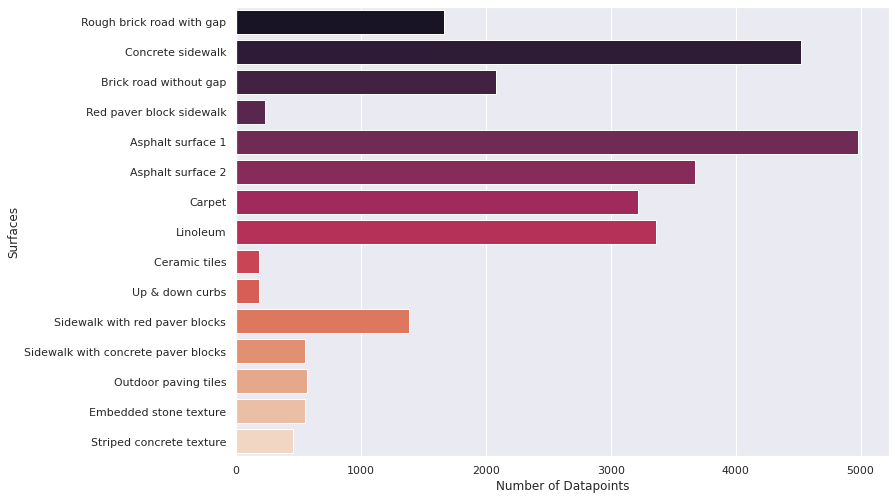

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
copy = pd.DataFrame({'cat': ['Rough brick road with gap', 'Concrete sidewalk','Brick road without gap', 'Red paver block sidewalk','Asphalt surface 1', 
                             'Asphalt surface 2','Carpet','Linoleum','Ceramic tiles', 'Up & down curbs','Sidewalk with red paver blocks','Sidewalk with concrete paver blocks',  
                             'Outdoor paving tiles', 'Embedded stone texture','Striped concrete texture'],
                     'val': [1666,4524,2085,232,4976,3672,3221,3366,184,185,1383,554,569,554,456]})
fig = sns.barplot(x="val",y="cat",palette="rocket", data=copy)
plt.xlabel("Number of Datapoints")
plt.ylabel("Surfaces")
# plt.title("Class Distribution of Wheelchair dataset")
plt.show(fig)

# Number of layers

In [ ]:
#Run this cell for CASE

df = pd.read_csv('/content/drive/MyDrive/HEXR/Data/CASE_2class.csv')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df[['class2']]).toarray())
df = df.join(df_ohe)

df.drop('class1', axis=1, inplace=True)
df.drop('class2', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('valence', axis=1, inplace=True)
df.drop('arousal', axis=1, inplace=True)
X = df.loc[:,:'emg_trap']
y = df.iloc[:,8:]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']] = scaler.fit_transform(X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']])


from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
15% :- Test 
10% of 85% = 8.5% :- Labelled dataset
90% of 85% = 76.5% :- Unlabelled dataset
"""
X_L, X_U, y_L, y_test = train_test_split(X,y,test_size=0.15,random_state=7) 

#converting to numpy arrays
X_L = X_L.iloc[:, :].values
y_L = y_L.iloc[:, :].values
X_U = X_U.iloc[:,:].values
y_test = y_test.iloc[:,:].values
X_L.shape, X_U.shape, y_L.shape, y_test.shape


x_train = X_L
y_train = y_L
x_test = X_U
y_test = y_test

In [ ]:
len(x_train[0])

8

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'
  
# Define output
results = np.zeros([len(model_sets)+2])

In [ ]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [ ]:
mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128
mlp_parameters['num_layers'] = 5

In [ ]:
# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from utils import convert_matrix_to_vector, convert_vector_to_matrix


def mlp(x_train, y_train, x_test, parameters):
  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  act_fn = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])

  # Build model
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
  for i in range(0,parameters['num_layers']):
    model.add(Dense(hidden_dim, activation = act_fn))  
    # model.add(Dense(hidden_dim, activation = act_fn))  
  model.add(Dense(label_dim, activation = 'softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', 
                metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)
  
  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)
  
  return y_test_hat

In [ ]:
# Self supervised training of encoder - 90% of train data.

# mlp_parameters = dict()
# mlp_parameters['hidden_dim'] = 100
# mlp_parameters['epochs'] = 100
# mlp_parameters['activation'] = 'relu'
# mlp_parameters['batch_size'] = 128
  
# Train VIME-Self
vime_self_parameters = dict()
vime_self_parameters['batch_size'] = 128
vime_self_parameters['epochs'] = 15
vime_self_encoder = vime_self(x_unlab, p_m, alpha, vime_self_parameters)
    
# Save encoder
if not os.path.exists('save_model'):
  os.makedirs('save_model')

file_name = '../Models/arousal_CASE_encoder.h5'
    
vime_self_encoder.save(file_name)  

Epoch 1/15
8792/8792 [==============================] - 28s 3ms/step - loss: 0.6214 - mask_loss: 0.6126 - feature_loss: 0.0044
Epoch 2/15
8792/8792 [==============================] - 34s 4ms/step - loss: 0.6186 - mask_loss: 0.6110 - feature_loss: 0.0038
Epoch 3/15
8792/8792 [==============================] - 38s 4ms/step - loss: 0.6181 - mask_loss: 0.6105 - feature_loss: 0.0038
Epoch 4/15
8792/8792 [==============================] - 38s 4ms/step - loss: 0.6169 - mask_loss: 0.6093 - feature_loss: 0.0038
Epoch 5/15
8792/8792 [==============================] - 31s 4ms/step - loss: 0.6164 - mask_loss: 0.6087 - feature_loss: 0.0038
Epoch 6/15
8792/8792 [==============================] - 20s 2ms/step - loss: 0.6158 - mask_loss: 0.6081 - feature_loss: 0.0038
Epoch 7/15
8792/8792 [==============================] - 20s 2ms/step - loss: 0.6149 - mask_loss: 0.6073 - feature_loss: 0.0038
Epoch 8/15
8792/8792 [==============================] - 20s 2ms/step - loss: 0.6142 - mask_loss: 0.6066 - featu

Proposed self supervised learning framework (param act function + log cosh loss)


In [ ]:
logistic_supervised_acc = []
logistic_supervised_auc = []
mlp_supervised_acc = []
mlp_supervised_auc = []
self_supervised_acc = []
self_supervised_auc = []

# mlp_parameters = dict()
# mlp_parameters['hidden_dim'] = 100
# mlp_parameters['epochs'] = 100
# mlp_parameters['activation'] = 'relu'
# mlp_parameters['batch_size'] = 128

from keras.models import load_model
vime_self_encoder = load_model('../Models/arousal_CASE_encoder.h5')

# for label_no in tqdm([1000,20000,40000,60000,80000,100000, len(label_idx)]):
  # x_t = x_train[:label_no, :]
  # y_t = y_train[:label_no, :]  

# y_test_hat = logit(x_train, y_train, x_test)
# logistic_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
# logistic_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

y_test_hat = mlp(x_train, y_train, x_test, mlp_parameters)
mlp_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
mlp_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  # Test VIME-Self
x_train_hat = vime_self_encoder.predict(x_train)
x_test_hat = vime_self_encoder.predict(x_test)
        
y_test_hat = mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
self_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
self_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

In [ ]:
self_supervised_acc

### test

In [ ]:
test_acc = []
test_auc = []

In [ ]:
y_test_hat = mlp(x_train, y_train, x_test, mlp_parameters)
test_acc.append(perf_metric(metric1, y_test, y_test_hat))
test_auc.append(perf_metric(metric2, y_test, y_test_hat))

In [ ]:
test_acc

[0.8098384728340675]

In [ ]:
for num in [1,2,3,4,5]:
  mlp_parameters = dict()
  mlp_parameters['hidden_dim'] = 100
  mlp_parameters['epochs'] = 100
  mlp_parameters['activation'] = 'relu'
  mlp_parameters['batch_size'] = 128
  mlp_parameters['num_layers'] = num
  y_test_hat = mlp(x_train, y_train, x_test, mlp_parameters)
  test_acc.append(perf_metric(metric1, y_test, y_test_hat))
  test_auc.append(perf_metric(metric2, y_test, y_test_hat))

In [ ]:
test_acc

[0.7304572070847156,
 0.8050388861695763,
 0.8399639237867333,
 0.8629783724007904,
 0.8795707111908776]

In [ ]:
test_auc

[0.7616231261866535,
 0.8668989689805209,
 0.9095225465013044,
 0.9288495973005831,
 0.9469470689578086]

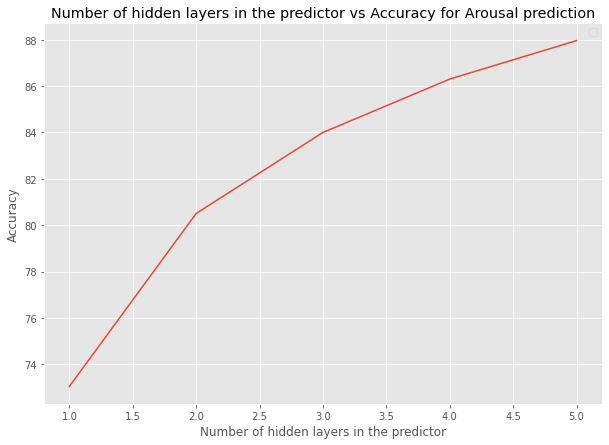

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

number_data = [1,2,3,4,5]
acc = np.array([0.7304572070847156,
 0.8050388861695763,
 0.8399639237867333,
 0.8629783724007904,
 0.8795707111908776])
auc = np.array([0.7616231261866535,
 0.8668989689805209,
 0.9095225465013044,
 0.9288495973005831,
 0.9469470689578086])

plt.figure(figsize = (10,7))
plt.title("Number of hidden layers in the predictor vs Accuracy for Arousal prediction")
plt.xlabel("Number of hidden layers in the predictor")
plt.ylabel("Accuracy")
plt.plot(number_data, acc*100, '-')
plt.legend()

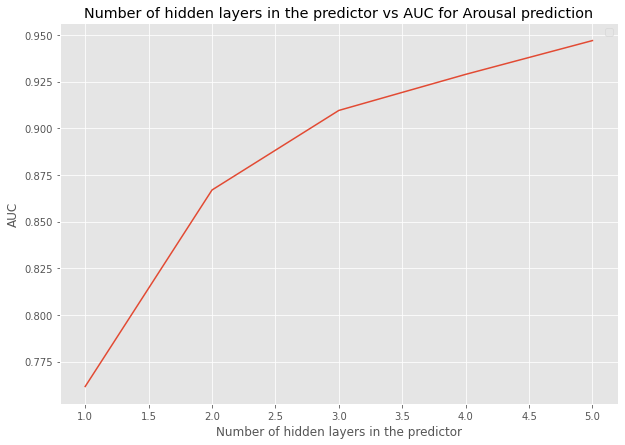

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

number_data = [1,2,3,4,5]
acc = np.array([0.7304572070847156,
 0.8050388861695763,
 0.8399639237867333,
 0.8629783724007904,
 0.8795707111908776])
auc = np.array([0.7616231261866535,
 0.8668989689805209,
 0.9095225465013044,
 0.9288495973005831,
 0.9469470689578086])

plt.figure(figsize = (10,7))
plt.title("Number of hidden layers in the predictor vs AUC for Arousal prediction")
plt.xlabel("Number of hidden layers in the predictor")
plt.ylabel("AUC")
plt.plot(number_data, auc, '-')
plt.legend()

# CASE - 80:20 tests - Arousal

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import supervised_models
import vime_self
import hexr_self
import utils
from supervised_models import logit, mlp
from utils import mask_generator, pretext_generator
from hexr_self import hexr_self
from vime_self import vime_self
from utils import perf_metric

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend

#to load VIME original

# from supervised_models import logit, mlp
# from vime_utils import mask_generator, pretext_generator
# from vime_self import vime_self
# from vime_utils import perf_metric

Arousal

In [ ]:
#Run this cell for CASE

df = pd.read_csv('/content/drive/MyDrive/HEXR/Data/CASE_2class.csv')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df[['class2']]).toarray())
df = df.join(df_ohe)

df.drop('class1', axis=1, inplace=True)
df.drop('class2', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('valence', axis=1, inplace=True)
df.drop('arousal', axis=1, inplace=True)
X = df.loc[:,:'emg_trap']
y = df.iloc[:,8:]


from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
20% :- Test 
10% of 80% = 8% :- Labelled dataset
90% of 80% = 72% :- Unlabelled dataset
"""
X_L, X_U, y_L, y_test = train_test_split(X,y,test_size=0.20,random_state=7) 

#converting to numpy arrays
X_L = X_L.iloc[:, :].values
y_L = y_L.iloc[:, :].values
X_U = X_U.iloc[:,:].values
y_test = y_test.iloc[:,:].values
X_L.shape, X_U.shape, y_L.shape, y_test.shape


x_train = X_L
y_train = y_L
x_test = X_U
y_test = y_test

In [ ]:
X_L.shape, X_U.shape, y_L.shape, y_test.shape

((1176768, 8), (294192, 8), (1176768, 2), (294192, 2))

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'

In [ ]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [ ]:
x_train.shape, x_unlab.shape

((117676, 8), (1059092, 8))

In [ ]:
len(x_train[0, :])

8

In [ ]:
""" 
Scaling for Original VIME
"""

"""Min-Max scaling only for original VIME"""

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']] = scaler.fit_transform(X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']])

from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
20% :- Test 
10% of 80% = 8% :- Labelled dataset
90% of 80% = 72% :- Unlabelled dataset
"""
X_L_vime, X_U_vime, y_L_vime, y_test_vime = train_test_split(X,y,test_size=0.20,random_state=7) 

#converting to numpy arrays
X_L_vime = X_L_vime.iloc[:, :].values
y_L_vime = y_L_vime.iloc[:, :].values
X_U_vime = X_U_vime.iloc[:,:].values
y_test_vime = y_test_vime.iloc[:,:].values

x_train_vime = X_L_vime
y_train_vime = y_L_vime
x_test_vime = X_U_vime
y_test_vime = y_test_vime

# Unlabeled data
x_unlab_vime = x_train_vime[unlab_idx, :]

# Labeled data
x_train_vime = x_train_vime[label_idx, :] 
y_train_vime = y_train_vime[label_idx, :]

In [ ]:
mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128
mlp_parameters['num_layers'] = 5

In [ ]:
"""
MLP suggested by HEXR
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend

from tensorflow.keras.layers import LeakyReLU

from utils import convert_matrix_to_vector, convert_vector_to_matrix

import math

"""
Parameterized Activation functions.
"""

"""
Initializing parameters. We observe that a initialization from Uniform distribution 
yield a better result than normal distribution.
"""

initializer0 = keras.initializers.RandomUniform(minval = -1, maxval =1)
initializer1 = keras.initializers.RandomUniform(minval = 0.5, maxval =3) 

def param_elliot_function( signal, k1, k2 ,  derivative=False ):
    """ A parameterized version of Elliot activation function """
    s = 1 # steepness
    
    abs_signal = (1 + tf.math.abs(signal * s))
    if derivative:
        return 0.5 * s / abs_signal**2
    else:
        # Return the activation signal
        return (k1*(signal * s) / abs_signal + k2)

class ParamElliotfn(keras.layers.Layer):
    def __init__(self, trainable = True):
        super(ParamElliotfn, self).__init__()
        self.k1 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
        self.k2 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
    def call(self, inputs):
        return param_elliot_function(inputs, self.k1, self.k2 )


def hexr_mlp(x_train, y_train, x_test, parameters):

  print("HEXR MLP")

  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  # K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  # Arelu = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])
  
  print("Supervised MLP training sing Parameterized Elliot activation.") 
  Elliot = ParamElliotfn()
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = Elliot))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = Elliot))  
  model.add(Dense(label_dim, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, restore_best_weights=True, patience=50)
  
  # print("Balancing classes") 
  # from sklearn.utils.class_weight import compute_sample_weight
  # sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid),epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)

  
  return y_test_hat

In [ ]:
"""VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain (VIME) Codebase.

Reference: Jinsung Yoon, Yao Zhang, James Jordon, Mihaela van der Schaar, 
"VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain," 
Neural Information Processing Systems (NeurIPS), 2020.
Paper link: TBD
Last updated Date: October 11th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------

supervised_models.py
- Train supervised model and return predictions on the testing data

(1) logit: logistic regression
(2) xgb_model: XGBoost model
(3) mlp: multi-layer perceptrons
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from utils import convert_matrix_to_vector, convert_vector_to_matrix

  
#%% 
def vime_mlp(x_train, y_train, x_test, parameters):
  print("VIME MLP")
  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  act_fn = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])

  # Build model
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = act_fn))  
  model.add(Dense(label_dim, activation = 'softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', 
                metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)
  
  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)
  
  return y_test_hat

In [ ]:
results_HEXR_acc = []
results_HEXR_auc = []
results_VIME_acc = []
results_VIME_auc = []
hexrSup_test_acc = []
hexrSup_test_auc = []
vimeSup_test_acc = []
vimeSup_test_auc = []


for i in range(0,5):

  mlp_parameters = dict()
  mlp_parameters['hidden_dim'] = 100
  mlp_parameters['epochs'] = 100
  mlp_parameters['activation'] = 'relu'
  mlp_parameters['batch_size'] = 128
  mlp_parameters['num_layers'] = 5
  
  #supervised - HEXR
  # y_test_hat = hexr_mlp(x_train, y_train, x_test, mlp_parameters)
  # mlp_perf1 = perf_metric(metric1, y_test, y_test_hat)
  # hexrSup_test_acc.append(mlp_perf1)
  # hexrSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  # print("HEXR MLP performance : {}".format(mlp_perf1))

  #supervised - VIME
  y_test_hat = vime_mlp(x_train, y_train, x_test, mlp_parameters)
  mlp_perf2 = perf_metric(metric1, y_test, y_test_hat)
  vimeSup_test_acc.append(mlp_perf2)
  vimeSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  print("VIME MLP performance : {}".format(mlp_perf2))

  # Train HEXR-Self 
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  hexr_self_encoder = hexr_self(x_unlab, p_m, alpha, vime_self_parameters)
    
  # Save encoder
  if not os.path.exists('save_model'):
    os.makedirs('save_model')

  file_name = './save_model/HEXR_encoder_model_arousal_{}.h5'.format(i)
    
  hexr_self_encoder.save(file_name)  
          
  # Test HEXR-Self
  x_train_hat = hexr_self_encoder.predict(x_train)
  x_test_hat = hexr_self_encoder.predict(x_test)
        
  y_test_hat1 = vime_mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
  res = perf_metric(metric1, y_test, y_test_hat1)
  results_HEXR_acc.append(perf_metric(metric1, y_test, y_test_hat1))
  results_HEXR_auc.append(perf_metric(metric2, y_test, y_test_hat1))
        
  print('HEXR-Self Performance: ' + str(res))

  #Train VIME self
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  vime_self_encoder = vime_self(x_unlab_vime, p_m, alpha, vime_self_parameters)

  file_name = './save_model/VIME_encoder_model_arousal_{}.h5'.format(i)
    
  vime_self_encoder.save(file_name)  
          
  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_train_vime)
  x_test_hat = vime_self_encoder.predict(x_test_vime)
        
  y_test_hat2 = vime_mlp(x_train_hat, y_train_vime, x_test_hat, mlp_parameters)
  res2 = perf_metric(metric1, y_test_vime, y_test_hat2)
  results_VIME_acc.append(res2)
  results_VIME_auc.append(perf_metric(metric2, y_test_vime, y_test_hat2))
        
  print('VIME-Self Performance: ' + str(res2))

VIME MLP
VIME MLP performance : 0.8528308043726546
Epoch 1/10
8275/8275 [==============================] - 32s 4ms/step - loss: 9.0780 - mask_loss: 0.6142 - feature_loss: 4.2319
Epoch 2/10
8275/8275 [==============================] - 30s 4ms/step - loss: 5.0796 - mask_loss: 0.6117 - feature_loss: 2.2339
Epoch 3/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.7996 - mask_loss: 0.6117 - feature_loss: 2.0939
Epoch 4/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.6749 - mask_loss: 0.6112 - feature_loss: 2.0318
Epoch 5/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.6482 - mask_loss: 0.6111 - feature_loss: 2.0186
Epoch 6/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.6272 - mask_loss: 0.6110 - feature_loss: 2.0081
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.6073 - mask_loss: 0.6108 - feature_loss: 1.9982
Epoch 8/10
8275/8275 [==============================] - 30s 

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8664749551313428
Epoch 1/10
8275/8275 [==============================] - 31s 4ms/step - loss: 0.6368 - mask_loss: 0.6120 - feature_loss: 0.0124
Epoch 2/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6258 - mask_loss: 0.6099 - feature_loss: 0.0080
Epoch 3/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6254 - mask_loss: 0.6096 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6251 - mask_loss: 0.6093 - feature_loss: 0.0079
Epoch 5/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6247 - mask_loss: 0.6089 - feature_loss: 0.0079
Epoch 6/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6243 - mask_loss: 0.6085 - feature_loss: 0.0079
Epoch 7/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6242 - mask_loss: 0.6084 - 

VIME MLP
VIME-Self Performance: 0.830321694675586
VIME MLP
VIME MLP performance : 0.8519878174797412
Epoch 1/10
8275/8275 [==============================] - 31s 4ms/step - loss: 9.7327 - mask_loss: 0.6128 - feature_loss: 4.5600
Epoch 2/10
8275/8275 [==============================] - 31s 4ms/step - loss: 5.6534 - mask_loss: 0.6117 - feature_loss: 2.5209
Epoch 3/10
8275/8275 [==============================] - 30s 4ms/step - loss: 5.0761 - mask_loss: 0.6114 - feature_loss: 2.2323
Epoch 4/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.6323 - mask_loss: 0.6114 - feature_loss: 2.0104
Epoch 5/10
8275/8275 [==============================] - 29s 4ms/step - loss: 4.4974 - mask_loss: 0.6114 - feature_loss: 1.9430
Epoch 6/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.4529 - mask_loss: 0.6113 - feature_loss: 1.9208
Epoch 7/10
8275/8275 [==============================] - 29s 4ms/step - loss: 4.4372 - mask_loss: 0.6112 - feature_loss: 1.9130
Epoch 8/10

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8709482242888997
Epoch 1/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6341 - mask_loss: 0.6120 - feature_loss: 0.0110
Epoch 2/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6262 - mask_loss: 0.6104 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6259 - mask_loss: 0.6102 - feature_loss: 0.0078
Epoch 4/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6255 - mask_loss: 0.6098 - feature_loss: 0.0079
Epoch 5/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6250 - mask_loss: 0.6091 - feature_loss: 0.0079
Epoch 6/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6241 - mask_loss: 0.6082 - feature_loss: 0.0080
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6234 - mask_loss: 0.6076 - 

VIME MLP
VIME-Self Performance: 0.8407842497416653
VIME MLP
VIME MLP performance : 0.842789742753032
Epoch 1/10
8275/8275 [==============================] - 32s 4ms/step - loss: 9.6769 - mask_loss: 0.6121 - feature_loss: 4.5324
Epoch 2/10
8275/8275 [==============================] - 29s 4ms/step - loss: 5.5404 - mask_loss: 0.6114 - feature_loss: 2.4645
Epoch 3/10
8275/8275 [==============================] - 29s 4ms/step - loss: 5.3284 - mask_loss: 0.6118 - feature_loss: 2.3583
Epoch 4/10
8275/8275 [==============================] - 29s 4ms/step - loss: 5.1489 - mask_loss: 0.6114 - feature_loss: 2.2687
Epoch 5/10
8275/8275 [==============================] - 29s 4ms/step - loss: 5.0565 - mask_loss: 0.6112 - feature_loss: 2.2227
Epoch 6/10
8275/8275 [==============================] - 29s 4ms/step - loss: 5.0128 - mask_loss: 0.6111 - feature_loss: 2.2008
Epoch 7/10
8275/8275 [==============================] - 29s 4ms/step - loss: 4.9831 - mask_loss: 0.6111 - feature_loss: 2.1860
Epoch 8/10

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8421541034426497
Epoch 1/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6342 - mask_loss: 0.6123 - feature_loss: 0.0110
Epoch 2/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6266 - mask_loss: 0.6107 - feature_loss: 0.0080
Epoch 3/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6261 - mask_loss: 0.6102 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6247 - mask_loss: 0.6090 - feature_loss: 0.0079
Epoch 5/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6243 - mask_loss: 0.6086 - feature_loss: 0.0079
Epoch 6/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6242 - mask_loss: 0.6085 - feature_loss: 0.0079
Epoch 7/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6241 - mask_loss: 0.6084 - 

VIME MLP
VIME-Self Performance: 0.8321300375265133
VIME MLP
VIME MLP performance : 0.8542414477620057
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 9.5441 - mask_loss: 0.6136 - feature_loss: 4.4652
Epoch 2/10
8275/8275 [==============================] - 29s 4ms/step - loss: 5.2892 - mask_loss: 0.6114 - feature_loss: 2.3389
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.9086 - mask_loss: 0.6125 - feature_loss: 2.1481
Epoch 4/10
8275/8275 [==============================] - 29s 4ms/step - loss: 4.6161 - mask_loss: 0.6116 - feature_loss: 2.0022
Epoch 5/10
8275/8275 [==============================] - 29s 4ms/step - loss: 4.5085 - mask_loss: 0.6114 - feature_loss: 1.9486
Epoch 6/10
8275/8275 [==============================] - 29s 4ms/step - loss: 4.3946 - mask_loss: 0.6113 - feature_loss: 1.8916
Epoch 7/10
8275/8275 [==============================] - 29s 4ms/step - loss: 4.3173 - mask_loss: 0.6112 - feature_loss: 1.8530
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8782903681949203
Epoch 1/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6365 - mask_loss: 0.6125 - feature_loss: 0.0120
Epoch 2/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6259 - mask_loss: 0.6100 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6252 - mask_loss: 0.6094 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6246 - mask_loss: 0.6090 - feature_loss: 0.0078
Epoch 5/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6243 - mask_loss: 0.6086 - feature_loss: 0.0078
Epoch 6/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6240 - mask_loss: 0.6083 - feature_loss: 0.0079
Epoch 7/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6239 - mask_loss: 0.6081 - 

VIME MLP
VIME-Self Performance: 0.8347337793005928
VIME MLP
VIME MLP performance : 0.8557914559199434
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 8.4240 - mask_loss: 0.6149 - feature_loss: 3.9045
Epoch 2/10
8275/8275 [==============================] - 29s 4ms/step - loss: 5.0926 - mask_loss: 0.6128 - feature_loss: 2.2399
Epoch 3/10
8275/8275 [==============================] - 29s 4ms/step - loss: 4.6679 - mask_loss: 0.6112 - feature_loss: 2.0283
Epoch 4/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.5673 - mask_loss: 0.6110 - feature_loss: 1.9781
Epoch 5/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.5246 - mask_loss: 0.6110 - feature_loss: 1.9568
Epoch 6/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.5008 - mask_loss: 0.6110 - feature_loss: 1.9449
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.4819 - mask_loss: 0.6110 - feature_loss: 1.9355
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8725016315875347
Epoch 1/10
8275/8275 [==============================] - 29s 3ms/step - loss: 0.6332 - mask_loss: 0.6124 - feature_loss: 0.0104
Epoch 2/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6252 - mask_loss: 0.6093 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6246 - mask_loss: 0.6089 - feature_loss: 0.0078
Epoch 4/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6244 - mask_loss: 0.6088 - feature_loss: 0.0078
Epoch 5/10
8275/8275 [==============================] - 28s 3ms/step - loss: 0.6243 - mask_loss: 0.6087 - feature_loss: 0.0078
Epoch 6/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6242 - mask_loss: 0.6086 - feature_loss: 0.0078
Epoch 7/10
8275/8275 [==============================] - 27s 3ms/step - loss: 0.6241 - mask_loss: 0.6085 - 

VIME MLP
VIME-Self Performance: 0.8437143090226791


In [ ]:
results_HEXR_acc, results_VIME_acc, vimeSup_test_acc

([0.8664749551313428,
  0.8709482242888997,
  0.8421541034426497,
  0.8782903681949203,
  0.8725016315875347],
 [0.830321694675586,
  0.8407842497416653,
  0.8321300375265133,
  0.8347337793005928,
  0.8437143090226791],
 [0.8528308043726546,
  0.8519878174797412,
  0.842789742753032,
  0.8542414477620057,
  0.8557914559199434])

In [ ]:
results_HEXR_auc, results_VIME_auc, vimeSup_test_auc

([0.9318493748623498,
  0.9363186295942663,
  0.9101540488094058,
  0.9412149383164254,
  0.9393188214347552],
 [0.8988885657177801,
  0.9127806885681823,
  0.9014813336765326,
  0.9047486201598045,
  0.9151798961523161],
 [0.919431777258732,
  0.9170922942889717,
  0.9106608405232736,
  0.9198239499789789,
  0.9221062750783958])

# Wheelchair

In [5]:
#Run this cell for Wheelchair

df_mw = pd.read_excel('/content/drive/MyDrive/WheelShare/Code/wheelchair.xlsx')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df_mw[['class']]).toarray())
df_mw = df_mw.join(df_ohe)

df_mw.drop('class', axis=1, inplace=True)
X = df_mw.loc[:,:'gyr_maxabssum']
y = df_mw.iloc[:,22:]


# from sklearn.preprocessing import MinMaxScaler


# scaler = MinMaxScaler()


# X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_L_mw, X_U_mw, y_L_mw, y_test_mw = train_test_split(X,y,test_size=0.20,random_state=7) #80-20 split

#converting to numpy arrays
X_L_mw = X_L_mw.iloc[:, :].values
y_L_mw = y_L_mw.iloc[:, :].values
X_U_mw = X_U_mw.iloc[:,:].values
y_test_mw = y_test_mw.iloc[:,:].values
X_L_mw.shape, X_U_mw.shape, y_L_mw.shape, y_test_mw.shape


x_train = X_L_mw
y_train = y_L_mw
x_test = X_U_mw
y_test = y_test_mw

In [6]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'

In [7]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [8]:
x_train.shape, x_unlab.shape

((2210, 22), (19891, 22))

In [9]:
len(x_train[0, :])

22

In [10]:
""" 
Scaling for Original VIME
"""

"""Min-Max scaling only for original VIME"""

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

# from sklearn.model_selection import train_test_split

# """
# Split used in accordance with VIME @ Neurips 2020 for comparison:
# 20% :- Test 
# 10% of 80% = 8% :- Labelled dataset
# 90% of 80% = 72% :- Unlabelled dataset
# """
# X_L_vime, X_U_vime, y_L_vime, y_test_vime = train_test_split(X,y,test_size=0.20,random_state=7) 

# #converting to numpy arrays
# # X_L_vime = X_L_vime.iloc[:, :].values
# y_L_vime = y_L_vime.iloc[:, :].values
# # X_U_vime = X_U_vime.iloc[:,:].values
# y_test_vime = y_test_vime.iloc[:,:].values


x_train_vime = X_L_mw
y_train_vime = y_L_mw
x_test_vime = X_U_mw
y_test_vime = y_test_mw

# Unlabeled data
x_unlab_vime = x_unlab

# Labeled data
x_train_vime = x_train
y_train_vime = y_train

In [11]:
mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128
mlp_parameters['num_layers'] = 4

In [12]:
"""
MLP suggested by HEXR
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend

from tensorflow.keras.layers import LeakyReLU

from utils import convert_matrix_to_vector, convert_vector_to_matrix

import math

"""
Parameterized Activation functions.
"""

"""
Initializing parameters. We observe that a initialization from Uniform distribution 
yield a better result than normal distribution.
"""

initializer0 = keras.initializers.RandomUniform(minval = -1, maxval =1)
initializer1 = keras.initializers.RandomUniform(minval = 0.5, maxval =3) 

def param_elliot_function( signal, k1, k2 ,  derivative=False ):
    """ A parameterized version of Elliot activation function """
    s = 1 # steepness
    
    abs_signal = (1 + tf.math.abs(signal * s))
    if derivative:
        return 0.5 * s / abs_signal**2
    else:
        # Return the activation signal
        return (k1*(signal * s) / abs_signal + k2)

class ParamElliotfn(keras.layers.Layer):
    def __init__(self, trainable = True):
        super(ParamElliotfn, self).__init__()
        self.k1 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
        self.k2 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
    def call(self, inputs):
        return param_elliot_function(inputs, self.k1, self.k2 )


def hexr_mlp(x_train, y_train, x_test, parameters):

  print("HEXR MLP")

  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  # K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  # Arelu = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])
  
  print("Supervised MLP training sing Parameterized Elliot activation.") 
  Elliot = ParamElliotfn()
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = Elliot))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = Elliot))  
  model.add(Dense(label_dim, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, restore_best_weights=True, patience=50)
  
  # print("Balancing classes") 
  # from sklearn.utils.class_weight import compute_sample_weight
  # sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid),epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)

  
  return y_test_hat

In [13]:
"""VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain (VIME) Codebase.

Reference: Jinsung Yoon, Yao Zhang, James Jordon, Mihaela van der Schaar, 
"VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain," 
Neural Information Processing Systems (NeurIPS), 2020.
Paper link: TBD
Last updated Date: October 11th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------

supervised_models.py
- Train supervised model and return predictions on the testing data

(1) logit: logistic regression
(2) xgb_model: XGBoost model
(3) mlp: multi-layer perceptrons
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from utils import convert_matrix_to_vector, convert_vector_to_matrix

  
#%% 
def vime_mlp(x_train, y_train, x_test, parameters):
  print("VIME MLP")
  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  act_fn = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])

  # Build model
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = act_fn))  
  model.add(Dense(label_dim, activation = 'softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', 
                metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)
  
  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)
  
  return y_test_hat

In [ ]:
"""
Wheelchair scaled results
"""

# results_HEXR_acc = []
# results_HEXR_auc = []
# results_VIME_acc = []
# results_VIME_auc = []
# hexrSup_test_acc = []
# hexrSup_test_auc = []
# vimeSup_test_acc = []
# vimeSup_test_auc = []


# for i in range(0,5):

#   mlp_parameters = dict()
#   mlp_parameters['hidden_dim'] = 100
#   mlp_parameters['epochs'] = 100
#   mlp_parameters['activation'] = 'relu'
#   mlp_parameters['batch_size'] = 32
#   mlp_parameters['num_layers'] = 4
  
#   #supervised - HEXR
#   # y_test_hat = hexr_mlp(x_train, y_train, x_test, mlp_parameters)
#   # mlp_perf1 = perf_metric(metric1, y_test, y_test_hat)
#   # hexrSup_test_acc.append(mlp_perf1)
#   # hexrSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
#   # print("HEXR MLP performance : {}".format(mlp_perf1))

#   #supervised - VIME
#   y_test_hat = vime_mlp(x_train, y_train, x_test, mlp_parameters)
#   mlp_perf2 = perf_metric(metric1, y_test, y_test_hat)
#   vimeSup_test_acc.append(mlp_perf2)
#   vimeSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
#   print("VIME MLP performance : {}".format(mlp_perf2))

#   # Train HEXR-Self 
#   vime_self_parameters = dict()
#   vime_self_parameters['batch_size'] = 128
#   vime_self_parameters['epochs'] = 10
#   hexr_self_encoder = hexr_self(x_unlab, p_m, alpha, vime_self_parameters)
    
#   # Save encoder
#   if not os.path.exists('save_model'):
#     os.makedirs('save_model')

#   file_name = './save_model/wheelchair_HEXR_encoder_model_{}.h5'.format(i)
    
#   hexr_self_encoder.save(file_name)  
          
#   # Test HEXR-Self
#   x_train_hat = hexr_self_encoder.predict(x_train)
#   x_test_hat = hexr_self_encoder.predict(x_test)
        
#   y_test_hat1 = vime_mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
#   res = perf_metric(metric1, y_test, y_test_hat1)
#   results_HEXR_acc.append(perf_metric(metric1, y_test, y_test_hat1))
#   results_HEXR_auc.append(perf_metric(metric2, y_test, y_test_hat1))
        
#   print('HEXR-Self Performance: ' + str(res))

#   #Train VIME self
#   vime_self_parameters = dict()
#   vime_self_parameters['batch_size'] = 128
#   vime_self_parameters['epochs'] = 10
#   vime_self_encoder = vime_self(x_unlab_vime, p_m, alpha, vime_self_parameters)

#   file_name = './save_model/Wheelchair_VIME_encoder_model_{}.h5'.format(i)
    
#   vime_self_encoder.save(file_name)  
          
#   # Test VIME-Self
#   x_train_hat = vime_self_encoder.predict(x_train_vime)
#   x_test_hat = vime_self_encoder.predict(x_test_vime)
        
#   y_test_hat2 = vime_mlp(x_train_hat, y_train_vime, x_test_hat, mlp_parameters)
#   res2 = perf_metric(metric1, y_test_vime, y_test_hat2)
#   results_VIME_acc.append(res2)
#   results_VIME_auc.append(perf_metric(metric2, y_test_vime, y_test_hat2))
        
#   print('VIME-Self Performance: ' + str(res2))

VIME MLP
Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping
VIME MLP performance : 0.6442272891784292
Epoch 1/10
156/156 [==============================] - 2s 4ms/step - loss: 1.0310 - mask_loss: 0.6544 - feature_loss: 0.1883
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9024 - mask_loss: 0.6156 - feature_loss: 0.1434
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8695 - mask_loss: 0.6145 - feature_loss: 0.1275
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8559 - mask_loss: 0.6137 - feature_loss: 0.1211
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8479 - mask_loss: 0.6131 - feature_loss: 0.1174
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8416 - mask_loss: 0.6129 - feature_loss: 0.1143
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8364 - mask_loss: 0.6127 - feature_loss: 0.1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping
HEXR-Self Performance: 0.5667752442996743
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 0.7587 - mask_loss: 0.6382 - feature_loss: 0.0603
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6197 - mask_loss: 0.6113 - feature_loss: 0.0042
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6139 - mask_loss: 0.6111 - feature_loss: 0.0014
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6137 - mask_loss: 0.6111 - feature_loss: 0.0013
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6136 - mask_loss: 0.6110 - feature_loss: 0.0013
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6135 - mask_loss: 0.6110 - feature_loss: 0.0012
Epoch 7/10
156/156 [===================

VIME MLP
VIME-Self Performance: 0.45620702135360114
VIME MLP
Restoring model weights from the end of the best epoch: 28.
Epoch 78: early stopping
VIME MLP performance : 0.6398841838581252
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0521 - mask_loss: 0.6352 - feature_loss: 0.2084
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8998 - mask_loss: 0.6165 - feature_loss: 0.1416
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8657 - mask_loss: 0.6146 - feature_loss: 0.1256
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8522 - mask_loss: 0.6136 - feature_loss: 0.1193
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8445 - mask_loss: 0.6130 - feature_loss: 0.1158
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8390 - mask_loss: 0.6125 - feature_loss: 0.1132
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - 

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping
HEXR-Self Performance: 0.6154542164314152
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 0.7265 - mask_loss: 0.6254 - feature_loss: 0.0506
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6146 - mask_loss: 0.6106 - feature_loss: 0.0020
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6133 - mask_loss: 0.6106 - feature_loss: 0.0014
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6132 - mask_loss: 0.6106 - feature_loss: 0.0013
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6131 - mask_loss: 0.6105 - feature_loss: 0.0013
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6130 - mask_loss: 0.6105 - feature_loss: 0.0013
Epoch 7/10
156/156 [===================

VIME MLP
VIME-Self Performance: 0.41512848353239235
VIME MLP
Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping
VIME MLP performance : 0.5826999638074557
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0301 - mask_loss: 0.6292 - feature_loss: 0.2004
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9248 - mask_loss: 0.6128 - feature_loss: 0.1560
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8830 - mask_loss: 0.6129 - feature_loss: 0.1350
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8638 - mask_loss: 0.6126 - feature_loss: 0.1256
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8529 - mask_loss: 0.6121 - feature_loss: 0.1204
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8454 - mask_loss: 0.6118 - feature_loss: 0.1168
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - 

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 30.
Epoch 80: early stopping
HEXR-Self Performance: 0.6103872602243938
Epoch 1/10
156/156 [==============================] - 2s 4ms/step - loss: 0.7313 - mask_loss: 0.6410 - feature_loss: 0.0451
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6144 - mask_loss: 0.6107 - feature_loss: 0.0018
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6132 - mask_loss: 0.6105 - feature_loss: 0.0013
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6131 - mask_loss: 0.6105 - feature_loss: 0.0013
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6129 - mask_loss: 0.6105 - feature_loss: 0.0012
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6128 - mask_loss: 0.6105 - feature_loss: 0.0012
Epoch 7/10
156/156 [===================

VIME MLP
VIME-Self Performance: 0.49022801302931596
VIME MLP
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping
VIME MLP performance : 0.6205211726384365
Epoch 1/10
156/156 [==============================] - 2s 7ms/step - loss: 1.1455 - mask_loss: 0.6310 - feature_loss: 0.2573
Epoch 2/10
156/156 [==============================] - 1s 6ms/step - loss: 0.9312 - mask_loss: 0.6156 - feature_loss: 0.1578
Epoch 3/10
156/156 [==============================] - 1s 6ms/step - loss: 0.8833 - mask_loss: 0.6155 - feature_loss: 0.1339
Epoch 4/10
156/156 [==============================] - 1s 5ms/step - loss: 0.8646 - mask_loss: 0.6146 - feature_loss: 0.1250
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8544 - mask_loss: 0.6140 - feature_loss: 0.1202
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8473 - mask_loss: 0.6136 - feature_loss: 0.1169
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - 

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 14.
Epoch 64: early stopping
HEXR-Self Performance: 0.5624321389793703
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 0.7252 - mask_loss: 0.6458 - feature_loss: 0.0397
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6156 - mask_loss: 0.6117 - feature_loss: 0.0020
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6143 - mask_loss: 0.6116 - feature_loss: 0.0013
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6142 - mask_loss: 0.6116 - feature_loss: 0.0013
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6141 - mask_loss: 0.6116 - feature_loss: 0.0013
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6140 - mask_loss: 0.6116 - feature_loss: 0.0012
Epoch 7/10
156/156 [===================

VIME MLP
VIME-Self Performance: 0.3858125226203402
VIME MLP
Restoring model weights from the end of the best epoch: 29.
Epoch 79: early stopping
VIME MLP performance : 0.6536373507057546
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0404 - mask_loss: 0.6545 - feature_loss: 0.1930
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9120 - mask_loss: 0.6128 - feature_loss: 0.1496
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8722 - mask_loss: 0.6122 - feature_loss: 0.1300
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8543 - mask_loss: 0.6117 - feature_loss: 0.1213
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8446 - mask_loss: 0.6113 - feature_loss: 0.1167
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8382 - mask_loss: 0.6109 - feature_loss: 0.1137
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - l

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping
HEXR-Self Performance: 0.574737604053565
Epoch 1/10
156/156 [==============================] - 2s 4ms/step - loss: 0.7433 - mask_loss: 0.6369 - feature_loss: 0.0532
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6180 - mask_loss: 0.6123 - feature_loss: 0.0029
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6148 - mask_loss: 0.6121 - feature_loss: 0.0014
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6147 - mask_loss: 0.6121 - feature_loss: 0.0013
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6147 - mask_loss: 0.6121 - feature_loss: 0.0013
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.6146 - mask_loss: 0.6120 - feature_loss: 0.0013
Epoch 7/10
156/156 [====================

VIME MLP
VIME-Self Performance: 0.37423090843286283


In [ ]:
"""
Wheelchair Not Scaled results
"""

# results_HEXR_acc = []
# results_HEXR_auc = []
# results_VIME_acc = []
# results_VIME_auc = []
# hexrSup_test_acc = []
# hexrSup_test_auc = []
# vimeSup_test_acc = []
# vimeSup_test_auc = []


# for i in range(0,5):

#   mlp_parameters = dict()
#   mlp_parameters['hidden_dim'] = 100
#   mlp_parameters['epochs'] = 100
#   mlp_parameters['activation'] = 'relu'
#   mlp_parameters['batch_size'] = 32
#   mlp_parameters['num_layers'] = 4
  
#   #supervised - HEXR
#   # y_test_hat = hexr_mlp(x_train, y_train, x_test, mlp_parameters)
#   # mlp_perf1 = perf_metric(metric1, y_test, y_test_hat)
#   # hexrSup_test_acc.append(mlp_perf1)
#   # hexrSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
#   # print("HEXR MLP performance : {}".format(mlp_perf1))

#   #supervised - VIME
#   y_test_hat = vime_mlp(x_train, y_train, x_test, mlp_parameters)
#   mlp_perf2 = perf_metric(metric1, y_test, y_test_hat)
#   vimeSup_test_acc.append(mlp_perf2)
#   vimeSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
#   print("VIME MLP performance : {}".format(mlp_perf2))

#   # Train HEXR-Self 
#   vime_self_parameters = dict()
#   vime_self_parameters['batch_size'] = 128
#   vime_self_parameters['epochs'] = 10
#   hexr_self_encoder = hexr_self(x_unlab, p_m, alpha, vime_self_parameters)
    
#   # Save encoder
#   if not os.path.exists('save_model'):
#     os.makedirs('save_model')

#   file_name = './save_model/wheelchair_HEXR_encoder_model_{}.h5'.format(i)
    
#   hexr_self_encoder.save(file_name)  
          
#   # Test HEXR-Self
#   x_train_hat = hexr_self_encoder.predict(x_train)
#   x_test_hat = hexr_self_encoder.predict(x_test)
        
#   y_test_hat1 = vime_mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
#   res = perf_metric(metric1, y_test, y_test_hat1)
#   results_HEXR_acc.append(perf_metric(metric1, y_test, y_test_hat1))
#   results_HEXR_auc.append(perf_metric(metric2, y_test, y_test_hat1))
        
#   print('HEXR-Self Performance: ' + str(res))

#   #Train VIME self
#   vime_self_parameters = dict()
#   vime_self_parameters['batch_size'] = 128
#   vime_self_parameters['epochs'] = 10
#   vime_self_encoder = vime_self(x_unlab_vime, p_m, alpha, vime_self_parameters)

#   file_name = './save_model/Wheelchair_VIME_encoder_model_{}.h5'.format(i)
    
#   vime_self_encoder.save(file_name)  
          
#   # Test VIME-Self
#   x_train_hat = vime_self_encoder.predict(x_train_vime)
#   x_test_hat = vime_self_encoder.predict(x_test_vime)
        
#   y_test_hat2 = vime_mlp(x_train_hat, y_train_vime, x_test_hat, mlp_parameters)
#   res2 = perf_metric(metric1, y_test_vime, y_test_hat2)
#   results_VIME_acc.append(res2)
#   results_VIME_auc.append(perf_metric(metric2, y_test_vime, y_test_hat2))
        
#   print('VIME-Self Performance: ' + str(res2))

VIME MLP
Restoring model weights from the end of the best epoch: 19.
Epoch 69: early stopping
VIME MLP performance : 0.6373507057546145
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0551 - mask_loss: 0.6346 - feature_loss: 0.2103
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9390 - mask_loss: 0.6117 - feature_loss: 0.1637
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8925 - mask_loss: 0.6121 - feature_loss: 0.1402
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8698 - mask_loss: 0.6121 - feature_loss: 0.1288
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8555 - mask_loss: 0.6119 - feature_loss: 0.1218
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8462 - mask_loss: 0.6116 - feature_loss: 0.1173
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8398 - mask_loss: 0.6113 - feature_loss: 0.1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping
HEXR-Self Performance: 0.568765834238147
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 2.8348 - mask_loss: 0.6730 - feature_loss: 1.0809
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3882 - mask_loss: 0.6327 - feature_loss: 0.8778
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.2272 - mask_loss: 0.6238 - feature_loss: 0.8017
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1700 - mask_loss: 0.6192 - feature_loss: 0.7754
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1427 - mask_loss: 0.6163 - feature_loss: 0.7632
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1273 - mask_loss: 0.6146 - feature_loss: 0.7564
Epoch 7/10
156/156 [====================

VIME MLP
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping
VIME-Self Performance: 0.5530220774520449
VIME MLP
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping
VIME MLP performance : 0.6585233441910966
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0315 - mask_loss: 0.6420 - feature_loss: 0.1947
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8896 - mask_loss: 0.6168 - feature_loss: 0.1364
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8571 - mask_loss: 0.6140 - feature_loss: 0.1216
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8446 - mask_loss: 0.6127 - feature_loss: 0.1160
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8370 - mask_loss: 0.6119 - feature_loss: 0.1125
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8316 - mask_loss: 0.6114 - featu

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.6833152370611654
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 2.8163 - mask_loss: 0.6788 - feature_loss: 1.0688
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3924 - mask_loss: 0.6357 - feature_loss: 0.8784
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.2242 - mask_loss: 0.6242 - feature_loss: 0.8000
Epoch 4/10
156/156 [==============================] - 1s 3ms/step - loss: 2.1626 - mask_loss: 0.6191 - feature_loss: 0.7717
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1366 - mask_loss: 0.6165 - feature_loss: 0.7601
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1225 - mask_loss: 0.6148 - feature_loss: 0.7538
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1138 - mask_loss: 0.6137 - feature_loss: 0.7501


VIME MLP
Restoring model weights from the end of the best epoch: 34.
Epoch 84: early stopping
VIME-Self Performance: 0.6083966702859211
VIME MLP
Restoring model weights from the end of the best epoch: 33.
Epoch 83: early stopping
VIME MLP performance : 0.6520086862106406
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.1015 - mask_loss: 0.6339 - feature_loss: 0.2338
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9212 - mask_loss: 0.6150 - feature_loss: 0.1531
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8763 - mask_loss: 0.6143 - feature_loss: 0.1310
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8571 - mask_loss: 0.6134 - feature_loss: 0.1219
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8466 - mask_loss: 0.6128 - feature_loss: 0.1169
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8395 - mask_loss: 0.6122 - featu

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 38.
Epoch 88: early stopping
HEXR-Self Performance: 0.6302931596091205
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 2.8339 - mask_loss: 0.6732 - feature_loss: 1.0803
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3820 - mask_loss: 0.6327 - feature_loss: 0.8746
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.2191 - mask_loss: 0.6240 - feature_loss: 0.7976
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1579 - mask_loss: 0.6192 - feature_loss: 0.7693
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1341 - mask_loss: 0.6164 - feature_loss: 0.7588
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1222 - mask_loss: 0.6145 - feature_loss: 0.7538
Epoch 7/10
156/156 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping
VIME-Self Performance: 0.5047050307636627
VIME MLP
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping
VIME MLP performance : 0.6547231270358306
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0832 - mask_loss: 0.6523 - feature_loss: 0.2154
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9085 - mask_loss: 0.6154 - feature_loss: 0.1465
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8715 - mask_loss: 0.6143 - feature_loss: 0.1286
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8547 - mask_loss: 0.6135 - feature_loss: 0.1206
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8448 - mask_loss: 0.6129 - feature_loss: 0.1160
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8383 - mask_loss: 0.6125 - featu

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 31.
Epoch 81: early stopping
HEXR-Self Performance: 0.6152732537097358
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 2.7844 - mask_loss: 0.6634 - feature_loss: 1.0605
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3674 - mask_loss: 0.6314 - feature_loss: 0.8680
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.2223 - mask_loss: 0.6232 - feature_loss: 0.7995
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1735 - mask_loss: 0.6191 - feature_loss: 0.7772
Epoch 5/10
156/156 [==============================] - 1s 3ms/step - loss: 2.1450 - mask_loss: 0.6168 - feature_loss: 0.7641
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1247 - mask_loss: 0.6153 - feature_loss: 0.7547
Epoch 7/10
156/156 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping
VIME-Self Performance: 0.6389793702497285
VIME MLP
Restoring model weights from the end of the best epoch: 24.
Epoch 74: early stopping
VIME MLP performance : 0.6389793702497285
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0135 - mask_loss: 0.6449 - feature_loss: 0.1843
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9025 - mask_loss: 0.6143 - feature_loss: 0.1441
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8709 - mask_loss: 0.6138 - feature_loss: 0.1285
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8539 - mask_loss: 0.6134 - feature_loss: 0.1203
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8445 - mask_loss: 0.6130 - feature_loss: 0.1158
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8384 - mask_loss: 0.6126 - featu

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 22.
Epoch 72: early stopping
HEXR-Self Performance: 0.5919290626131017
Epoch 1/10
156/156 [==============================] - 2s 4ms/step - loss: 2.8028 - mask_loss: 0.6809 - feature_loss: 1.0609
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3662 - mask_loss: 0.6334 - feature_loss: 0.8664
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.2179 - mask_loss: 0.6244 - feature_loss: 0.7967
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1667 - mask_loss: 0.6198 - feature_loss: 0.7735
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1435 - mask_loss: 0.6172 - feature_loss: 0.7632
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1304 - mask_loss: 0.6156 - feature_loss: 0.7574
Epoch 7/10
156/156 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 26.
Epoch 76: early stopping
VIME-Self Performance: 0.6007962359753891


In [22]:
results_HEXR_acc = []
results_HEXR_f1_mic = []
results_HEXR_f1_mac = []
results_HEXR_f1_wei = []

results_VIME_acc = []
results_VIME_f1_mic = []
results_VIME_f1_mac = []
results_VIME_f1_wei = []

vimeSup_test_acc = []
vimeSup_test_f1_mic = []
vimeSup_test_f1_mac = []
vimeSup_test_f1_wei = []

for i in range(0,5):

  mlp_parameters = dict()
  mlp_parameters['hidden_dim'] = 100
  mlp_parameters['epochs'] = 100
  mlp_parameters['activation'] = 'relu'
  mlp_parameters['batch_size'] = 32
  mlp_parameters['num_layers'] = 4
  
  #supervised - HEXR
  # y_test_hat = hexr_mlp(x_train, y_train, x_test, mlp_parameters)
  # mlp_perf1 = perf_metric(metric1, y_test, y_test_hat)
  # hexrSup_test_acc.append(mlp_perf1)
  # hexrSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  # print("HEXR MLP performance : {}".format(mlp_perf1))

  #supervised - VIME
  y_test_hat = vime_mlp(x_train, y_train, x_test, mlp_parameters)
  mlp_perf2 = perf_metric(metric1, y_test, y_test_hat)
  vimeSup_test_acc.append(mlp_perf2)
  # vimeSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  vimeSup_test_f1_mic.append(f1_score(y_test.argmax(1),y_test_hat.argmax(1),average="micro"))
  vimeSup_test_f1_mac.append(f1_score(y_test.argmax(1),y_test_hat.argmax(1),average="macro"))
  vimeSup_test_f1_wei.append(f1_score(y_test.argmax(1),y_test_hat.argmax(1),average="weighted"))
  print("VIME MLP performance : {}".format(mlp_perf2))

  # Train HEXR-Self 
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  hexr_self_encoder = hexr_self(x_unlab, p_m, alpha, vime_self_parameters)
    
  # Save encoder
  if not os.path.exists('save_model'):
    os.makedirs('save_model')

  file_name = './save_model/wheelchair_HEXR_encoder_model_{}.h5'.format(i)
    
  hexr_self_encoder.save(file_name)  
          
  # Test HEXR-Self
  x_train_hat = hexr_self_encoder.predict(x_train)
  x_test_hat = hexr_self_encoder.predict(x_test)
        
  y_test_hat1 = vime_mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
  res = perf_metric(metric1, y_test, y_test_hat1)
  results_HEXR_acc.append(perf_metric(metric1, y_test, y_test_hat1))
  # results_HEXR_auc.append(perf_metric(metric2, y_test, y_test_hat1))
  results_HEXR_f1_mic.append(f1_score(y_test.argmax(1),y_test_hat1.argmax(1),average="micro"))
  results_HEXR_f1_mac.append(f1_score(y_test.argmax(1),y_test_hat1.argmax(1),average="macro"))
  results_HEXR_f1_wei.append(f1_score(y_test.argmax(1),y_test_hat1.argmax(1),average="weighted"))
        
  print('HEXR-Self Performance: ' + str(res))

  #Train VIME self
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  vime_self_encoder = vime_self(x_unlab_vime, p_m, alpha, vime_self_parameters)

  file_name = './save_model/Wheelchair_VIME_encoder_model_{}.h5'.format(i)
    
  vime_self_encoder.save(file_name)  
          
  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_train_vime)
  x_test_hat = vime_self_encoder.predict(x_test_vime)
        
  y_test_hat2 = vime_mlp(x_train_hat, y_train_vime, x_test_hat, mlp_parameters)
  res2 = perf_metric(metric1, y_test_vime, y_test_hat2)
  results_VIME_acc.append(res2)
  # results_VIME_auc.append(perf_metric(metric2, y_test_vime, y_test_hat2))
  results_VIME_f1_mic.append(f1_score(y_test.argmax(1),y_test_hat2.argmax(1),average="micro"))
  results_VIME_f1_mac.append(f1_score(y_test.argmax(1),y_test_hat2.argmax(1),average="macro"))
  results_VIME_f1_wei.append(f1_score(y_test.argmax(1),y_test_hat2.argmax(1),average="weighted"))
        
  print('VIME-Self Performance: ' + str(res2))

VIME MLP
Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping
VIME MLP performance : 0.6409699601882012
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0503 - mask_loss: 0.6462 - feature_loss: 0.2021
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8927 - mask_loss: 0.6172 - feature_loss: 0.1377
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8594 - mask_loss: 0.6153 - feature_loss: 0.1220
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8454 - mask_loss: 0.6141 - feature_loss: 0.1157
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8376 - mask_loss: 0.6133 - feature_loss: 0.1122
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8322 - mask_loss: 0.6127 - feature_loss: 0.1097
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8280 - mask_loss: 0.6123 - feature_loss: 0.1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 28.
Epoch 78: early stopping
HEXR-Self Performance: 0.6199782844733985
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 2.7773 - mask_loss: 0.6593 - feature_loss: 1.0590
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3317 - mask_loss: 0.6322 - feature_loss: 0.8497
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1729 - mask_loss: 0.6234 - feature_loss: 0.7747
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1200 - mask_loss: 0.6188 - feature_loss: 0.7506
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 2.0979 - mask_loss: 0.6162 - feature_loss: 0.7408
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.0858 - mask_loss: 0.6146 - feature_loss: 0.7356
Epoch 7/10
156/156 [===================

VIME MLP
VIME-Self Performance: 0.6800579080709374
VIME MLP
Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping
VIME MLP performance : 0.6317408613825551
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0807 - mask_loss: 0.6359 - feature_loss: 0.2224
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8994 - mask_loss: 0.6159 - feature_loss: 0.1418
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8641 - mask_loss: 0.6145 - feature_loss: 0.1248
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8503 - mask_loss: 0.6134 - feature_loss: 0.1185
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8420 - mask_loss: 0.6128 - feature_loss: 0.1146
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8357 - mask_loss: 0.6124 - feature_loss: 0.1117
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - l

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.6585233441910966
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 2.7904 - mask_loss: 0.6779 - feature_loss: 1.0562
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3410 - mask_loss: 0.6340 - feature_loss: 0.8535
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1794 - mask_loss: 0.6251 - feature_loss: 0.7771
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1308 - mask_loss: 0.6205 - feature_loss: 0.7552
Epoch 5/10
156/156 [==============================] - 1s 3ms/step - loss: 2.1094 - mask_loss: 0.6178 - feature_loss: 0.7458
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.0972 - mask_loss: 0.6160 - feature_loss: 0.7406
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - loss: 2.0891 - mask_loss: 0.6148 - feature_loss: 0.7372


VIME MLP
Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping
VIME-Self Performance: 0.6331885631559898
VIME MLP
Restoring model weights from the end of the best epoch: 30.
Epoch 80: early stopping
VIME MLP performance : 0.6639522258414766
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.1217 - mask_loss: 0.6587 - feature_loss: 0.2315
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9087 - mask_loss: 0.6162 - feature_loss: 0.1463
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8707 - mask_loss: 0.6156 - feature_loss: 0.1276
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8545 - mask_loss: 0.6145 - feature_loss: 0.1200
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8454 - mask_loss: 0.6137 - feature_loss: 0.1159
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8391 - mask_loss: 0.6131 - featu

VIME MLP
Restoring model weights from the end of the best epoch: 45.
Epoch 95: early stopping
HEXR-Self Performance: 0.6617806731813246
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 2.7696 - mask_loss: 0.6630 - feature_loss: 1.0533
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3376 - mask_loss: 0.6305 - feature_loss: 0.8535
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1865 - mask_loss: 0.6221 - feature_loss: 0.7822
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1356 - mask_loss: 0.6183 - feature_loss: 0.7586
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1115 - mask_loss: 0.6162 - feature_loss: 0.7476
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.0977 - mask_loss: 0.6149 - feature_loss: 0.7414
Epoch 7/10
156/156 [==============================] - 1s 4ms/step - loss: 2.0886 - mask_loss: 0.6137 - feature_loss: 0.7

VIME MLP
Restoring model weights from the end of the best epoch: 44.
Epoch 94: early stopping
VIME-Self Performance: 0.6197973217517192
VIME MLP
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping
VIME MLP performance : 0.6250452406804198
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.0296 - mask_loss: 0.6524 - feature_loss: 0.1886
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8800 - mask_loss: 0.6178 - feature_loss: 0.1311
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8518 - mask_loss: 0.6140 - feature_loss: 0.1189
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8410 - mask_loss: 0.6126 - feature_loss: 0.1142
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8342 - mask_loss: 0.6118 - feature_loss: 0.1112
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8292 - mask_loss: 0.6114 - featu

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 39.
Epoch 89: early stopping
HEXR-Self Performance: 0.6549040897575099
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 2.8022 - mask_loss: 0.6637 - feature_loss: 1.0692
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 2.3631 - mask_loss: 0.6322 - feature_loss: 0.8655
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 2.2011 - mask_loss: 0.6242 - feature_loss: 0.7885
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1415 - mask_loss: 0.6200 - feature_loss: 0.7607
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1134 - mask_loss: 0.6174 - feature_loss: 0.7480
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1004 - mask_loss: 0.6157 - feature_loss: 0.7423
Epoch 7/10
156/156 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 33.
Epoch 83: early stopping
VIME-Self Performance: 0.6112920738327905
VIME MLP
Restoring model weights from the end of the best epoch: 15.
Epoch 65: early stopping
VIME MLP performance : 0.6120159247195078
Epoch 1/10
156/156 [==============================] - 1s 4ms/step - loss: 1.1259 - mask_loss: 0.6460 - feature_loss: 0.2399
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9628 - mask_loss: 0.6126 - feature_loss: 0.1751
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.9026 - mask_loss: 0.6138 - feature_loss: 0.1444
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8763 - mask_loss: 0.6141 - feature_loss: 0.1311
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8628 - mask_loss: 0.6136 - feature_loss: 0.1246
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.8540 - mask_loss: 0.6132 - featu

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping
HEXR-Self Performance: 0.6514657980456026
Epoch 1/10
156/156 [==============================] - 1s 5ms/step - loss: 2.8190 - mask_loss: 0.6628 - feature_loss: 1.0781
Epoch 2/10
156/156 [==============================] - 1s 5ms/step - loss: 2.3701 - mask_loss: 0.6314 - feature_loss: 0.8694
Epoch 3/10
156/156 [==============================] - 1s 5ms/step - loss: 2.1863 - mask_loss: 0.6220 - feature_loss: 0.7822
Epoch 4/10
156/156 [==============================] - 1s 5ms/step - loss: 2.1318 - mask_loss: 0.6176 - feature_loss: 0.7571
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 2.1089 - mask_loss: 0.6152 - feature_loss: 0.7468
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 2.0962 - mask_loss: 0.6137 - feature_loss: 0.7412
Epoch 7/10
156/156 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 22.
Epoch 72: early stopping
VIME-Self Performance: 0.5971769815418024


In [23]:
vimeSup_test_acc, vimeSup_test_f1_mic, vimeSup_test_f1_mac, vimeSup_test_f1_wei 

([0.6409699601882012,
  0.6317408613825551,
  0.6639522258414766,
  0.6250452406804198,
  0.6120159247195078],
 [0.6409699601882012,
  0.6317408613825551,
  0.6639522258414766,
  0.6250452406804198,
  0.6120159247195078],
 [0.6277151390773057,
  0.5996344959210832,
  0.6526474299845427,
  0.5943494132668649,
  0.5869793682422312],
 [0.6388904832617054,
  0.6260778374929318,
  0.6657357799435839,
  0.6192602169828794,
  0.6044063782737684])

In [24]:
results_VIME_acc, results_VIME_f1_mic, results_VIME_f1_mac, results_VIME_f1_wei

([0.6800579080709374,
  0.6331885631559898,
  0.6197973217517192,
  0.6112920738327905,
  0.5971769815418024],
 [0.6800579080709374,
  0.6331885631559898,
  0.6197973217517192,
  0.6112920738327905,
  0.5971769815418024],
 [0.6179744242929867,
  0.5947296086292674,
  0.5538969427255159,
  0.5583678935922659,
  0.5619414182951014],
 [0.6770715938729363,
  0.6331013154382023,
  0.6197102676916542,
  0.6116687830488349,
  0.5922036273520355])

In [25]:
results_HEXR_acc, results_HEXR_f1_mic, results_HEXR_f1_mac, results_HEXR_f1_wei 

([0.6199782844733985,
  0.6585233441910966,
  0.6617806731813246,
  0.6549040897575099,
  0.6514657980456026],
 [0.6199782844733985,
  0.6585233441910966,
  0.6617806731813246,
  0.6549040897575099,
  0.6514657980456026],
 [0.5924165616521727,
  0.6179317769010513,
  0.62028747691979,
  0.6206521173503444,
  0.636171835903368],
 [0.6226149900536975,
  0.6617421132892208,
  0.6605057169437578,
  0.6493065639090537,
  0.6498938418550188])

run 1

In [19]:
vimeSup_test_acc, vimeSup_test_f1_mic, vimeSup_test_f1_mac, vimeSup_test_f1_wei 

([0.6554469779225479,
  0.67661961635903,
  0.6245023525153819,
  0.6769815418023887,
  0.6114730365544698],
 [0.6554469779225479,
  0.67661961635903,
  0.6245023525153819,
  0.6769815418023887,
  0.6114730365544698],
 [0.6329428506637226,
  0.6182678404552042,
  0.5774491036712645,
  0.6570032461990539,
  0.5902053882637301],
 [0.655170333494531,
  0.6742586020260256,
  0.6240530548592805,
  0.6720374118416572,
  0.6095703408310962])

In [20]:
results_VIME_acc, results_VIME_f1_mic, results_VIME_f1_mac, results_VIME_f1_wei

([0.6232356134636265,
  0.5564603691639523,
  0.6500180962721679,
  0.5993485342019544,
  0.6503800217155266],
 [0.6554469779225479,
  0.67661961635903,
  0.6245023525153819,
  0.6769815418023887,
  0.6114730365544698],
 [0.6329428506637226,
  0.6182678404552042,
  0.5774491036712645,
  0.6570032461990539,
  0.5902053882637301],
 [0.655170333494531,
  0.6742586020260256,
  0.6240530548592805,
  0.6720374118416572,
  0.6095703408310962])

In [21]:
results_HEXR_acc, results_HEXR_f1_mic, results_HEXR_f1_mac, results_HEXR_f1_wei 

([0.6259500542888164,
  0.6114730365544698,
  0.6301121968874411,
  0.6315598986608758,
  0.5906623235613464],
 [0.6554469779225479,
  0.67661961635903,
  0.6245023525153819,
  0.6769815418023887,
  0.6114730365544698],
 [0.6329428506637226,
  0.6182678404552042,
  0.5774491036712645,
  0.6570032461990539,
  0.5902053882637301],
 [0.655170333494531,
  0.6742586020260256,
  0.6240530548592805,
  0.6720374118416572,
  0.6095703408310962])

# Income

In [ ]:
#Run this cell for UCI income

df_mw = pd.read_csv('/content/drive/MyDrive/HEXR/Data/adult_income.csv')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df_mw[['income']]).toarray())
df_mw.drop('Unnamed: 0', axis=1, inplace=True)
df_mw = df_mw.join(df_ohe)

df_mw.drop('income', axis=1, inplace=True)
X = df_mw.loc[:,:'marital_status']
y = df_mw.iloc[:,13:]

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()


X[['age', 'fnlwgt', 'education.num', 'occupation', 'relationship',
       'capital.gain', 'capital.loss', 'hours.per.week', 'gender', 'ethnicity',
       'native_country', 'work', 'marital_status']] = scaler.fit_transform(X[['age', 'fnlwgt', 'education.num', 'occupation', 'relationship',
       'capital.gain', 'capital.loss', 'hours.per.week', 'gender', 'ethnicity',
       'native_country', 'work', 'marital_status']])

# # tf.random.experimental.Generator.from_seed(1)

from sklearn.model_selection import train_test_split
#50-50% split
X_L_mw, X_U_mw, y_L_mw, y_test_mw = train_test_split(X,y,test_size=0.2,random_state=7) #20-80 split

#converting to numpy arrays
X_L_mw = X_L_mw.iloc[:, :].values
y_L_mw = y_L_mw.iloc[:, :].values
X_U_mw = X_U_mw.iloc[:,:].values
y_test_mw = y_test_mw.iloc[:,:].values
X_L_mw.shape, X_U_mw.shape, y_L_mw.shape, y_test_mw.shape


x_train = X_L_mw
y_train = y_L_mw
x_test = X_U_mw
y_test = y_test_mw

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'

In [ ]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [ ]:
x_train.shape, x_unlab.shape

((2604, 13), (23444, 13))

In [ ]:
len(x_train[0, :])

13

In [ ]:
x_train_vime = X_L_mw
y_train_vime = y_L_mw
x_test_vime = X_U_mw
y_test_vime = y_test_mw

# Unlabeled data
x_unlab_vime = x_unlab

# Labeled data
x_train_vime = x_train
y_train_vime = y_train

In [ ]:
mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128
mlp_parameters['num_layers'] = 5

In [ ]:
"""
MLP suggested by HEXR
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend

from tensorflow.keras.layers import LeakyReLU

from utils import convert_matrix_to_vector, convert_vector_to_matrix

import math

"""
Parameterized Activation functions.
"""

"""
Initializing parameters. We observe that a initialization from Uniform distribution 
yield a better result than normal distribution.
"""

initializer0 = keras.initializers.RandomUniform(minval = -1, maxval =1)
initializer1 = keras.initializers.RandomUniform(minval = 0.5, maxval =3) 

def param_elliot_function( signal, k1, k2 ,  derivative=False ):
    """ A parameterized version of Elliot activation function """
    s = 1 # steepness
    
    abs_signal = (1 + tf.math.abs(signal * s))
    if derivative:
        return 0.5 * s / abs_signal**2
    else:
        # Return the activation signal
        return (k1*(signal * s) / abs_signal + k2)

class ParamElliotfn(keras.layers.Layer):
    def __init__(self, trainable = True):
        super(ParamElliotfn, self).__init__()
        self.k1 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
        self.k2 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
    def call(self, inputs):
        return param_elliot_function(inputs, self.k1, self.k2 )


def hexr_mlp(x_train, y_train, x_test, parameters):

  print("HEXR MLP")

  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  # K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  # Arelu = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])
  
  print("Supervised MLP training sing Parameterized Elliot activation.") 
  Elliot = ParamElliotfn()
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = Elliot))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = Elliot))  
  model.add(Dense(label_dim, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, restore_best_weights=True, patience=50)
  
  # print("Balancing classes") 
  # from sklearn.utils.class_weight import compute_sample_weight
  # sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid),epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)

  
  return y_test_hat

In [ ]:
"""VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain (VIME) Codebase.

Reference: Jinsung Yoon, Yao Zhang, James Jordon, Mihaela van der Schaar, 
"VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain," 
Neural Information Processing Systems (NeurIPS), 2020.
Paper link: TBD
Last updated Date: October 11th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------

supervised_models.py
- Train supervised model and return predictions on the testing data

(1) logit: logistic regression
(2) xgb_model: XGBoost model
(3) mlp: multi-layer perceptrons
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from utils import convert_matrix_to_vector, convert_vector_to_matrix

  
#%% 
def vime_mlp(x_train, y_train, x_test, parameters):
  print("VIME MLP")
  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  act_fn = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])

  # Build model
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = act_fn))  
  model.add(Dense(label_dim, activation = 'softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', 
                metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)
  
  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)
  
  return y_test_hat

In [ ]:
results_HEXR_acc = []
results_HEXR_auc = []
results_VIME_acc = []
results_VIME_auc = []
hexrSup_test_acc = []
hexrSup_test_auc = []
vimeSup_test_acc = []
vimeSup_test_auc = []


for i in range(0,5):

  mlp_parameters = dict()
  mlp_parameters['hidden_dim'] = 100
  mlp_parameters['epochs'] = 100
  mlp_parameters['activation'] = 'relu'
  mlp_parameters['batch_size'] = 128
  mlp_parameters['num_layers'] = 5
  
  #supervised - HEXR
  # y_test_hat = hexr_mlp(x_train, y_train, x_test, mlp_parameters)
  # mlp_perf1 = perf_metric(metric1, y_test, y_test_hat)
  # hexrSup_test_acc.append(mlp_perf1)
  # hexrSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  # print("HEXR MLP performance : {}".format(mlp_perf1))

  #supervised - VIME
  y_test_hat = vime_mlp(x_train, y_train, x_test, mlp_parameters)
  mlp_perf2 = perf_metric(metric1, y_test, y_test_hat)
  vimeSup_test_acc.append(mlp_perf2)
  vimeSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  print("VIME MLP performance : {}".format(mlp_perf2))

  # Train HEXR-Self 
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  hexr_self_encoder = hexr_self(x_unlab, p_m, alpha, vime_self_parameters)
    
  # Save encoder
  if not os.path.exists('save_model'):
    os.makedirs('save_model')

  file_name = './save_model/HEXR_encoder_model_arousal_{}.h5'.format(i)
    
  hexr_self_encoder.save(file_name)  
          
  # Test HEXR-Self
  x_train_hat = hexr_self_encoder.predict(x_train)
  x_test_hat = hexr_self_encoder.predict(x_test)
        
  y_test_hat1 = vime_mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
  res = perf_metric(metric1, y_test, y_test_hat1)
  results_HEXR_acc.append(perf_metric(metric1, y_test, y_test_hat1))
  results_HEXR_auc.append(perf_metric(metric2, y_test, y_test_hat1))
        
  print('HEXR-Self Performance: ' + str(res))

  #Train VIME self
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  vime_self_encoder = vime_self(x_unlab_vime, p_m, alpha, vime_self_parameters)

  file_name = './save_model/VIME_encoder_model_arousal_{}.h5'.format(i)
    
  vime_self_encoder.save(file_name)  
          
  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_train_vime)
  x_test_hat = vime_self_encoder.predict(x_test_vime)
        
  y_test_hat2 = vime_mlp(x_train_hat, y_train_vime, x_test_hat, mlp_parameters)
  res2 = perf_metric(metric1, y_test_vime, y_test_hat2)
  results_VIME_acc.append(res2)
  results_VIME_auc.append(perf_metric(metric2, y_test_vime, y_test_hat2))
        
  print('VIME-Self Performance: ' + str(res2))

VIME MLP
VIME MLP performance : 0.8521237831076304
Epoch 1/10
8275/8275 [==============================] - 33s 4ms/step - loss: 8.5617 - mask_loss: 0.6132 - feature_loss: 3.9743
Epoch 2/10
8275/8275 [==============================] - 33s 4ms/step - loss: 5.0845 - mask_loss: 0.6124 - feature_loss: 2.2360
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.7186 - mask_loss: 0.6117 - feature_loss: 2.0535
Epoch 4/10
8275/8275 [==============================] - 33s 4ms/step - loss: 4.6627 - mask_loss: 0.6112 - feature_loss: 2.0258
Epoch 5/10
8275/8275 [==============================] - 33s 4ms/step - loss: 4.6447 - mask_loss: 0.6110 - feature_loss: 2.0169
Epoch 6/10
8275/8275 [==============================] - 35s 4ms/step - loss: 4.6281 - mask_loss: 0.6110 - feature_loss: 2.0085
Epoch 7/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.6069 - mask_loss: 0.6111 - feature_loss: 1.9979
Epoch 8/10
8275/8275 [==============================] - 33s 

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8616005873715125
Epoch 1/10
8275/8275 [==============================] - 30s 3ms/step - loss: 0.6322 - mask_loss: 0.6123 - feature_loss: 0.0100
Epoch 2/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6266 - mask_loss: 0.6108 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6256 - mask_loss: 0.6099 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 29s 3ms/step - loss: 0.6253 - mask_loss: 0.6095 - feature_loss: 0.0079
Epoch 5/10
8275/8275 [==============================] - 31s 4ms/step - loss: 0.6251 - mask_loss: 0.6094 - feature_loss: 0.0079
Epoch 6/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6249 - mask_loss: 0.6093 - feature_loss: 0.0078
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6249 - mask_loss: 0.6092 - 

VIME MLP
VIME-Self Performance: 0.8343292815576222
VIME MLP
VIME MLP performance : 0.850329036819492
Epoch 1/10
8275/8275 [==============================] - 34s 4ms/step - loss: 8.5267 - mask_loss: 0.6136 - feature_loss: 3.9565
Epoch 2/10
8275/8275 [==============================] - 31s 4ms/step - loss: 5.0170 - mask_loss: 0.6116 - feature_loss: 2.2027
Epoch 3/10
8275/8275 [==============================] - 34s 4ms/step - loss: 4.6934 - mask_loss: 0.6117 - feature_loss: 2.0409
Epoch 4/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.5748 - mask_loss: 0.6114 - feature_loss: 1.9817
Epoch 5/10
8275/8275 [==============================] - 33s 4ms/step - loss: 4.4853 - mask_loss: 0.6115 - feature_loss: 1.9369
Epoch 6/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.3980 - mask_loss: 0.6113 - feature_loss: 1.8933
Epoch 7/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.3527 - mask_loss: 0.6112 - feature_loss: 1.8707
Epoch 8/10

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8649725349431664
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6313 - mask_loss: 0.6117 - feature_loss: 0.0098
Epoch 2/10
8275/8275 [==============================] - 31s 4ms/step - loss: 0.6266 - mask_loss: 0.6106 - feature_loss: 0.0080
Epoch 3/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6261 - mask_loss: 0.6102 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 31s 4ms/step - loss: 0.6255 - mask_loss: 0.6097 - feature_loss: 0.0079
Epoch 5/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6249 - mask_loss: 0.6092 - feature_loss: 0.0079
Epoch 6/10
8275/8275 [==============================] - 31s 4ms/step - loss: 0.6248 - mask_loss: 0.6090 - feature_loss: 0.0079
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6247 - mask_loss: 0.6089 - 

VIME MLP
VIME-Self Performance: 0.8216912764453146
VIME MLP
VIME MLP performance : 0.8469536901071409
Epoch 1/10
8275/8275 [==============================] - 33s 4ms/step - loss: 8.7803 - mask_loss: 0.6154 - feature_loss: 4.0825
Epoch 2/10
8275/8275 [==============================] - 31s 4ms/step - loss: 5.1957 - mask_loss: 0.6118 - feature_loss: 2.2919
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.7463 - mask_loss: 0.6117 - feature_loss: 2.0673
Epoch 4/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.5541 - mask_loss: 0.6116 - feature_loss: 1.9712
Epoch 5/10
8275/8275 [==============================] - 34s 4ms/step - loss: 4.4573 - mask_loss: 0.6115 - feature_loss: 1.9229
Epoch 6/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.3884 - mask_loss: 0.6114 - feature_loss: 1.8885
Epoch 7/10
8275/8275 [==============================] - 34s 4ms/step - loss: 4.3526 - mask_loss: 0.6114 - feature_loss: 1.8706
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8633205525643117
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6360 - mask_loss: 0.6131 - feature_loss: 0.0114
Epoch 2/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6265 - mask_loss: 0.6107 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6263 - mask_loss: 0.6105 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 29s 3ms/step - loss: 0.6263 - mask_loss: 0.6105 - feature_loss: 0.0079
Epoch 5/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6263 - mask_loss: 0.6105 - feature_loss: 0.0079
Epoch 6/10
8275/8275 [==============================] - 29s 3ms/step - loss: 0.6263 - mask_loss: 0.6105 - feature_loss: 0.0079
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6263 - mask_loss: 0.6105 - 

VIME MLP
VIME-Self Performance: 0.8237375591450481
VIME MLP
VIME MLP performance : 0.8581946483928863
Epoch 1/10
8275/8275 [==============================] - 32s 4ms/step - loss: 8.6540 - mask_loss: 0.6148 - feature_loss: 4.0196
Epoch 2/10
8275/8275 [==============================] - 31s 4ms/step - loss: 5.1190 - mask_loss: 0.6117 - feature_loss: 2.2537
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.7255 - mask_loss: 0.6117 - feature_loss: 2.0569
Epoch 4/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.5551 - mask_loss: 0.6116 - feature_loss: 1.9718
Epoch 5/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.4665 - mask_loss: 0.6115 - feature_loss: 1.9275
Epoch 6/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.4269 - mask_loss: 0.6115 - feature_loss: 1.9077
Epoch 7/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.4071 - mask_loss: 0.6114 - feature_loss: 1.8978
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8220107956708544
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6324 - mask_loss: 0.6121 - feature_loss: 0.0102
Epoch 2/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6262 - mask_loss: 0.6103 - feature_loss: 0.0080
Epoch 3/10
8275/8275 [==============================] - 29s 3ms/step - loss: 0.6251 - mask_loss: 0.6093 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 29s 3ms/step - loss: 0.6245 - mask_loss: 0.6087 - feature_loss: 0.0079
Epoch 5/10
8275/8275 [==============================] - 29s 3ms/step - loss: 0.6242 - mask_loss: 0.6084 - feature_loss: 0.0079
Epoch 6/10
8275/8275 [==============================] - 29s 3ms/step - loss: 0.6240 - mask_loss: 0.6082 - feature_loss: 0.0079
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6238 - mask_loss: 0.6081 - 

VIME MLP
VIME-Self Performance: 0.8200630880513406
VIME MLP
VIME MLP performance : 0.8486634578778485
Epoch 1/10
8275/8275 [==============================] - 34s 4ms/step - loss: 8.7144 - mask_loss: 0.6157 - feature_loss: 4.0494
Epoch 2/10
8275/8275 [==============================] - 31s 4ms/step - loss: 5.1041 - mask_loss: 0.6113 - feature_loss: 2.2464
Epoch 3/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.8153 - mask_loss: 0.6115 - feature_loss: 2.1019
Epoch 4/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.6617 - mask_loss: 0.6113 - feature_loss: 2.0252
Epoch 5/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.6011 - mask_loss: 0.6113 - feature_loss: 1.9949
Epoch 6/10
8275/8275 [==============================] - 30s 4ms/step - loss: 4.5647 - mask_loss: 0.6112 - feature_loss: 1.9767
Epoch 7/10
8275/8275 [==============================] - 31s 4ms/step - loss: 4.5372 - mask_loss: 0.6111 - feature_loss: 1.9630
Epoch 8/1

KeyboardInterrupt: ignored

# MNIST

In [ ]:
from data_loader_fashion import load_fmnist_data
from data_loader_m import load_mnist_data

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'

In [ ]:
# Load data
x_train, y_train, x_unlab, x_test, y_test = load_mnist_data(label_data_rate)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Unlabeled data
x_unlab_vime = x_unlab

# Labeled data
x_train_vime = x_train
y_train_vime = y_train
x_test_vime = x_test
y_test_vime = y_test

In [ ]:
"""
MLP suggested by HEXR
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend

from tensorflow.keras.layers import LeakyReLU

from utils import convert_matrix_to_vector, convert_vector_to_matrix

import math

"""
Parameterized Activation functions.
"""

"""
Initializing parameters. We observe that a initialization from Uniform distribution 
yield a better result than normal distribution.
"""

initializer0 = keras.initializers.RandomUniform(minval = -1, maxval =1)
initializer1 = keras.initializers.RandomUniform(minval = 0.5, maxval =3) 

def param_elliot_function( signal, k1, k2 ,  derivative=False ):
    """ A parameterized version of Elliot activation function """
    s = 1 # steepness
    
    abs_signal = (1 + tf.math.abs(signal * s))
    if derivative:
        return 0.5 * s / abs_signal**2
    else:
        # Return the activation signal
        return (k1*(signal * s) / abs_signal + k2)

class ParamElliotfn(keras.layers.Layer):
    def __init__(self, trainable = True):
        super(ParamElliotfn, self).__init__()
        self.k1 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
        self.k2 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
    def call(self, inputs):
        return param_elliot_function(inputs, self.k1, self.k2 )


def hexr_mlp(x_train, y_train, x_test, parameters):

  print("HEXR MLP")

  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  # K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  # Arelu = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])
  
  print("Supervised MLP training sing Parameterized Elliot activation.") 
  Elliot = ParamElliotfn()
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = Elliot))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = Elliot))  
  model.add(Dense(label_dim, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, restore_best_weights=True, patience=50)
  
  # print("Balancing classes") 
  # from sklearn.utils.class_weight import compute_sample_weight
  # sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid),epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)

  
  return y_test_hat

In [ ]:
"""VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain (VIME) Codebase.

Reference: Jinsung Yoon, Yao Zhang, James Jordon, Mihaela van der Schaar, 
"VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain," 
Neural Information Processing Systems (NeurIPS), 2020.
Paper link: TBD
Last updated Date: October 11th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------

supervised_models.py
- Train supervised model and return predictions on the testing data

(1) logit: logistic regression
(2) xgb_model: XGBoost model
(3) mlp: multi-layer perceptrons
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from utils import convert_matrix_to_vector, convert_vector_to_matrix

  
#%% 
def vime_mlp(x_train, y_train, x_test, parameters):
  print("VIME MLP")
  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  act_fn = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])

  # Build model
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = act_fn))  
  model.add(Dense(label_dim, activation = 'softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', 
                metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)
  
  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)
  
  return y_test_hat

In [ ]:
results_HEXR_acc = []
results_HEXR_auc = []
results_VIME_acc = []
results_VIME_auc = []
hexrSup_test_acc = []
hexrSup_test_auc = []
vimeSup_test_acc = []
vimeSup_test_auc = []


for i in range(0,5):

  mlp_parameters = dict()
  mlp_parameters['hidden_dim'] = 100
  mlp_parameters['epochs'] = 100
  mlp_parameters['activation'] = 'relu'
  mlp_parameters['batch_size'] = 128
  mlp_parameters['num_layers'] = 3
  
  #supervised - HEXR
  # y_test_hat = hexr_mlp(x_train, y_train, x_test, mlp_parameters)
  # mlp_perf1 = perf_metric(metric1, y_test, y_test_hat)
  # hexrSup_test_acc.append(mlp_perf1)
  # hexrSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  # print("HEXR MLP performance : {}".format(mlp_perf1))

  #supervised - VIME
  y_test_hat = vime_mlp(x_train, y_train, x_test, mlp_parameters)
  mlp_perf2 = perf_metric(metric1, y_test, y_test_hat)
  vimeSup_test_acc.append(mlp_perf2)
  vimeSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  print("VIME MLP performance : {}".format(mlp_perf2))

  # Train HEXR-Self 
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  hexr_self_encoder = hexr_self(x_unlab, p_m, alpha, vime_self_parameters)
    
  # Save encoder
  if not os.path.exists('save_model'):
    os.makedirs('save_model')

  file_name = './save_model/HEXR_encoder_model_arousal_{}.h5'.format(i)
    
  hexr_self_encoder.save(file_name)  
          
  # Test HEXR-Self
  x_train_hat = hexr_self_encoder.predict(x_train)
  x_test_hat = hexr_self_encoder.predict(x_test)
        
  y_test_hat1 = vime_mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
  res = perf_metric(metric1, y_test, y_test_hat1)
  results_HEXR_acc.append(perf_metric(metric1, y_test, y_test_hat1))
  results_HEXR_auc.append(perf_metric(metric2, y_test, y_test_hat1))
        
  print('HEXR-Self Performance: ' + str(res))

  #Train VIME self
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  vime_self_encoder = vime_self(x_unlab_vime, p_m, alpha, vime_self_parameters)

  file_name = './save_model/VIME_encoder_model_arousal_{}.h5'.format(i)
    
  vime_self_encoder.save(file_name)  
          
  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_train_vime)
  x_test_hat = vime_self_encoder.predict(x_test_vime)
        
  y_test_hat2 = vime_mlp(x_train_hat, y_train_vime, x_test_hat, mlp_parameters)
  res2 = perf_metric(metric1, y_test_vime, y_test_hat2)
  results_VIME_acc.append(res2)
  results_VIME_auc.append(perf_metric(metric2, y_test_vime, y_test_hat2))
        
  print('VIME-Self Performance: ' + str(res2))

VIME MLP
Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping
VIME MLP performance : 0.9322
Epoch 1/10
422/422 [==============================] - 4s 8ms/step - loss: 0.2801 - mask_loss: 0.2262 - feature_loss: 0.0270
Epoch 2/10
422/422 [==============================] - 3s 8ms/step - loss: 0.2361 - mask_loss: 0.2172 - feature_loss: 0.0095
Epoch 3/10
422/422 [==============================] - 3s 7ms/step - loss: 0.2321 - mask_loss: 0.2154 - feature_loss: 0.0083
Epoch 4/10
422/422 [==============================] - 3s 8ms/step - loss: 0.2295 - mask_loss: 0.2137 - feature_loss: 0.0079
Epoch 5/10
422/422 [==============================] - 3s 8ms/step - loss: 0.2269 - mask_loss: 0.2115 - feature_loss: 0.0077
Epoch 6/10
422/422 [==============================] - 3s 6ms/step - loss: 0.2241 - mask_loss: 0.2087 - feature_loss: 0.0077
Epoch 7/10
422/422 [==============================] - 4s 9ms/step - loss: 0.2211 - mask_loss: 0.2058 - feature_loss: 0.0077
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping
HEXR-Self Performance: 0.9502
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 0.2789 - mask_loss: 0.2267 - feature_loss: 0.0261
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2439 - mask_loss: 0.2167 - feature_loss: 0.0136
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2360 - mask_loss: 0.2126 - feature_loss: 0.0117
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2299 - mask_loss: 0.2083 - feature_loss: 0.0108
Epoch 5/10
422/422 [==============================] - 3s 8ms/step - loss: 0.2240 - mask_loss: 0.2034 - feature_loss: 0.0103
Epoch 6/10
422/422 [==============================] - 4s 9ms/step - loss: 0.2184 - mask_loss: 0.1984 - feature_loss: 0.0100
Epoch 7/10
422/422 [==============================]

VIME MLP
Restoring model weights from the end of the best epoch: 6.
Epoch 56: early stopping
VIME-Self Performance: 0.9462
VIME MLP
Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping
VIME MLP performance : 0.9409
Epoch 1/10
422/422 [==============================] - 4s 5ms/step - loss: 0.2855 - mask_loss: 0.2274 - feature_loss: 0.0290
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2393 - mask_loss: 0.2185 - feature_loss: 0.0104
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2336 - mask_loss: 0.2168 - feature_loss: 0.0084
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2311 - mask_loss: 0.2156 - feature_loss: 0.0077
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2292 - mask_loss: 0.2144 - feature_loss: 0.0074
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2274 - mask_loss: 0.2129 - feature_loss: 0.0072
Epoch 7/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 8.
Epoch 58: early stopping
HEXR-Self Performance: 0.9427
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 0.2788 - mask_loss: 0.2266 - feature_loss: 0.0261
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2439 - mask_loss: 0.2167 - feature_loss: 0.0136
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2360 - mask_loss: 0.2126 - feature_loss: 0.0117
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2299 - mask_loss: 0.2083 - feature_loss: 0.0108
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2241 - mask_loss: 0.2035 - feature_loss: 0.0103
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2185 - mask_loss: 0.1985 - feature_loss: 0.0100
Epoch 7/10
422/422 [==============================] 

VIME MLP
Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping
VIME-Self Performance: 0.9519
VIME MLP
Restoring model weights from the end of the best epoch: 15.
Epoch 65: early stopping
VIME MLP performance : 0.9417
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 0.2621 - mask_loss: 0.2248 - feature_loss: 0.0187
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2345 - mask_loss: 0.2166 - feature_loss: 0.0089
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2313 - mask_loss: 0.2149 - feature_loss: 0.0082
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2290 - mask_loss: 0.2132 - feature_loss: 0.0079
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2266 - mask_loss: 0.2111 - feature_loss: 0.0077
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2241 - mask_loss: 0.2087 - feature_loss: 0.0077
Epoch 7/

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping
HEXR-Self Performance: 0.9483
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 0.2790 - mask_loss: 0.2267 - feature_loss: 0.0262
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2439 - mask_loss: 0.2167 - feature_loss: 0.0136
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2359 - mask_loss: 0.2125 - feature_loss: 0.0117
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2296 - mask_loss: 0.2080 - feature_loss: 0.0108
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2236 - mask_loss: 0.2030 - feature_loss: 0.0103
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2178 - mask_loss: 0.1979 - feature_loss: 0.0100
Epoch 7/10
422/422 [==============================]

VIME MLP
Restoring model weights from the end of the best epoch: 9.
Epoch 59: early stopping
VIME-Self Performance: 0.9488
VIME MLP
Restoring model weights from the end of the best epoch: 8.
Epoch 58: early stopping
VIME MLP performance : 0.9384
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 0.2624 - mask_loss: 0.2249 - feature_loss: 0.0187
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2345 - mask_loss: 0.2167 - feature_loss: 0.0089
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2314 - mask_loss: 0.2151 - feature_loss: 0.0082
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2292 - mask_loss: 0.2134 - feature_loss: 0.0079
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2268 - mask_loss: 0.2114 - feature_loss: 0.0077
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2242 - mask_loss: 0.2090 - feature_loss: 0.0076
Epoch 7/10

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 14.
Epoch 64: early stopping
HEXR-Self Performance: 0.9452
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 0.2790 - mask_loss: 0.2266 - feature_loss: 0.0262
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2441 - mask_loss: 0.2167 - feature_loss: 0.0137
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2361 - mask_loss: 0.2127 - feature_loss: 0.0117
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2300 - mask_loss: 0.2084 - feature_loss: 0.0108
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2242 - mask_loss: 0.2035 - feature_loss: 0.0103
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2185 - mask_loss: 0.1985 - feature_loss: 0.0100
Epoch 7/10
422/422 [==============================]

VIME MLP
Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping
VIME-Self Performance: 0.9483
VIME MLP
Restoring model weights from the end of the best epoch: 8.
Epoch 58: early stopping
VIME MLP performance : 0.9361
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 0.2581 - mask_loss: 0.2275 - feature_loss: 0.0153
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2355 - mask_loss: 0.2174 - feature_loss: 0.0091
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2328 - mask_loss: 0.2160 - feature_loss: 0.0084
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2311 - mask_loss: 0.2148 - feature_loss: 0.0081
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2294 - mask_loss: 0.2136 - feature_loss: 0.0079
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2277 - mask_loss: 0.2122 - feature_loss: 0.0078
Epoch 7/10

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping
HEXR-Self Performance: 0.9343
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 0.2791 - mask_loss: 0.2266 - feature_loss: 0.0262
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2439 - mask_loss: 0.2166 - feature_loss: 0.0136
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2359 - mask_loss: 0.2125 - feature_loss: 0.0117
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2297 - mask_loss: 0.2081 - feature_loss: 0.0108
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2236 - mask_loss: 0.2031 - feature_loss: 0.0103
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.2180 - mask_loss: 0.1980 - feature_loss: 0.0100
Epoch 7/10
422/422 [==============================] 

VIME MLP
Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping
VIME-Self Performance: 0.9471


In [ ]:
results_HEXR_acc, results_VIME_acc, vimeSup_test_acc

([0.9502, 0.9427, 0.9483, 0.9452, 0.9343],
 [0.9462, 0.9519, 0.9488, 0.9483, 0.9471],
 [0.9322, 0.9409, 0.9417, 0.9384, 0.9361])

In [ ]:
results_HEXR_auc, results_VIME_auc, vimeSup_test_auc

([0.9990916115695294,
  0.9992334354524922,
  0.999527121208733,
  0.9996340605907009,
  0.9986694196600501],
 [0.9993696937170629,
  0.9991768847941839,
  0.9994725582712792,
  0.9996069282010381,
  0.9995908276621173],
 [0.9993445490482544,
  0.9991974577050272,
  0.9992230993040492,
  0.9989202700318781,
  0.9990983698204343])

# FMNIST

In [ ]:
from data_loader_fashion import load_fmnist_data
from data_loader_m import load_mnist_data

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'

In [ ]:
# Load data
x_train, y_train, x_unlab, x_test, y_test = load_fmnist_data(label_data_rate)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# Unlabeled data
x_unlab_vime = x_unlab

# Labeled data
x_train_vime = x_train
y_train_vime = y_train
x_test_vime = x_test
y_test_vime = y_test

In [ ]:
"""
MLP suggested by HEXR
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend

from tensorflow.keras.layers import LeakyReLU

from utils import convert_matrix_to_vector, convert_vector_to_matrix

import math

"""
Parameterized Activation functions.
"""

"""
Initializing parameters. We observe that a initialization from Uniform distribution 
yield a better result than normal distribution.
"""

initializer0 = keras.initializers.RandomUniform(minval = -1, maxval =1)
initializer1 = keras.initializers.RandomUniform(minval = 0.5, maxval =3) 

def param_elliot_function( signal, k1, k2 ,  derivative=False ):
    """ A parameterized version of Elliot activation function """
    s = 1 # steepness
    
    abs_signal = (1 + tf.math.abs(signal * s))
    if derivative:
        return 0.5 * s / abs_signal**2
    else:
        # Return the activation signal
        return (k1*(signal * s) / abs_signal + k2)

class ParamElliotfn(keras.layers.Layer):
    def __init__(self, trainable = True):
        super(ParamElliotfn, self).__init__()
        self.k1 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
        self.k2 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
    def call(self, inputs):
        return param_elliot_function(inputs, self.k1, self.k2 )


def hexr_mlp(x_train, y_train, x_test, parameters):

  print("HEXR MLP")

  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  # K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  # Arelu = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])
  
  print("Supervised MLP training sing Parameterized Elliot activation.") 
  Elliot = ParamElliotfn()
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = Elliot))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = Elliot))  
  model.add(Dense(label_dim, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, restore_best_weights=True, patience=50)
  
  # print("Balancing classes") 
  # from sklearn.utils.class_weight import compute_sample_weight
  # sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid),epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)

  
  return y_test_hat

In [ ]:
"""VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain (VIME) Codebase.

Reference: Jinsung Yoon, Yao Zhang, James Jordon, Mihaela van der Schaar, 
"VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain," 
Neural Information Processing Systems (NeurIPS), 2020.
Paper link: TBD
Last updated Date: October 11th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------

supervised_models.py
- Train supervised model and return predictions on the testing data

(1) logit: logistic regression
(2) xgb_model: XGBoost model
(3) mlp: multi-layer perceptrons
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from utils import convert_matrix_to_vector, convert_vector_to_matrix

  
#%% 
def vime_mlp(x_train, y_train, x_test, parameters):
  print("VIME MLP")
  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  act_fn = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])

  # Build model
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = act_fn))  
  model.add(Dense(label_dim, activation = 'softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', 
                metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)
  
  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)
  
  return y_test_hat

In [ ]:
results_HEXR_acc = []
results_HEXR_auc = []
results_VIME_acc = []
results_VIME_auc = []
hexrSup_test_acc = []
hexrSup_test_auc = []
vimeSup_test_acc = []
vimeSup_test_auc = []


for i in range(0,5):

  mlp_parameters = dict()
  mlp_parameters['hidden_dim'] = 100
  mlp_parameters['epochs'] = 100
  mlp_parameters['activation'] = 'relu'
  mlp_parameters['batch_size'] = 128
  mlp_parameters['num_layers'] = 3
  
  #supervised - HEXR
  # y_test_hat = hexr_mlp(x_train, y_train, x_test, mlp_parameters)
  # mlp_perf1 = perf_metric(metric1, y_test, y_test_hat)
  # hexrSup_test_acc.append(mlp_perf1)
  # hexrSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  # print("HEXR MLP performance : {}".format(mlp_perf1))

  #supervised - VIME
  y_test_hat = vime_mlp(x_train, y_train, x_test, mlp_parameters)
  mlp_perf2 = perf_metric(metric1, y_test, y_test_hat)
  vimeSup_test_acc.append(mlp_perf2)
  vimeSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  print("VIME MLP performance : {}".format(mlp_perf2))

  # Train HEXR-Self 
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  hexr_self_encoder = hexr_self(x_unlab, p_m, alpha, vime_self_parameters)
    
  # Save encoder
  if not os.path.exists('save_model'):
    os.makedirs('save_model')

  file_name = './save_model/HEXR_encoder_model_arousal_{}.h5'.format(i)
    
  hexr_self_encoder.save(file_name)  
          
  # Test HEXR-Self
  x_train_hat = hexr_self_encoder.predict(x_train)
  x_test_hat = hexr_self_encoder.predict(x_test)
        
  y_test_hat1 = vime_mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
  res = perf_metric(metric1, y_test, y_test_hat1)
  results_HEXR_acc.append(perf_metric(metric1, y_test, y_test_hat1))
  results_HEXR_auc.append(perf_metric(metric2, y_test, y_test_hat1))
        
  print('HEXR-Self Performance: ' + str(res))

  #Train VIME self
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  vime_self_encoder = vime_self(x_unlab_vime, p_m, alpha, vime_self_parameters)

  file_name = './save_model/VIME_encoder_model_arousal_{}.h5'.format(i)
    
  vime_self_encoder.save(file_name)  
          
  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_train_vime)
  x_test_hat = vime_self_encoder.predict(x_test_vime)
        
  y_test_hat2 = vime_mlp(x_train_hat, y_train_vime, x_test_hat, mlp_parameters)
  res2 = perf_metric(metric1, y_test_vime, y_test_hat2)
  results_VIME_acc.append(res2)
  results_VIME_auc.append(perf_metric(metric2, y_test_vime, y_test_hat2))
        
  print('VIME-Self Performance: ' + str(res2))

VIME MLP
Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping
VIME MLP performance : 0.8503571428571428
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.5068 - mask_loss: 0.4602 - feature_loss: 0.0233
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4798 - mask_loss: 0.4553 - feature_loss: 0.0122
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4738 - mask_loss: 0.4540 - feature_loss: 0.0099
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4705 - mask_loss: 0.4527 - feature_loss: 0.0089
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4679 - mask_loss: 0.4511 - feature_loss: 0.0084
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4652 - mask_loss: 0.4488 - feature_loss: 0.0082
Epoch 7/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4620 - mask_loss: 0.4456 - feature_loss: 0.0

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 39.
Epoch 89: early stopping
HEXR-Self Performance: 0.8582142857142857
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.5336 - mask_loss: 0.4662 - feature_loss: 0.0337
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4962 - mask_loss: 0.4558 - feature_loss: 0.0202
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4834 - mask_loss: 0.4494 - feature_loss: 0.0170
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4730 - mask_loss: 0.4420 - feature_loss: 0.0155
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4633 - mask_loss: 0.4342 - feature_loss: 0.0146
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4548 - mask_loss: 0.4268 - feature_loss: 0.0140
Epoch 7/10
394/394 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 9.
Epoch 59: early stopping
VIME-Self Performance: 0.8522142857142857
VIME MLP
Restoring model weights from the end of the best epoch: 19.
Epoch 69: early stopping
VIME MLP performance : 0.8490714285714286
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.4962 - mask_loss: 0.4608 - feature_loss: 0.0177
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4780 - mask_loss: 0.4552 - feature_loss: 0.0114
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4738 - mask_loss: 0.4538 - feature_loss: 0.0100
Epoch 4/10
394/394 [==============================] - 2s 6ms/step - loss: 0.4710 - mask_loss: 0.4525 - feature_loss: 0.0092
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4688 - mask_loss: 0.4512 - feature_loss: 0.0088
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4666 - mask_loss: 0.4496 - featur

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 23.
Epoch 73: early stopping
HEXR-Self Performance: 0.8527142857142858
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.5335 - mask_loss: 0.4659 - feature_loss: 0.0338
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4963 - mask_loss: 0.4557 - feature_loss: 0.0203
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4832 - mask_loss: 0.4493 - feature_loss: 0.0170
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4729 - mask_loss: 0.4420 - feature_loss: 0.0154
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4631 - mask_loss: 0.4341 - feature_loss: 0.0145
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4545 - mask_loss: 0.4266 - feature_loss: 0.0139
Epoch 7/10
394/394 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping
VIME-Self Performance: 0.8517142857142858
VIME MLP
Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping
VIME MLP performance : 0.8566428571428572
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.5124 - mask_loss: 0.4607 - feature_loss: 0.0259
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4800 - mask_loss: 0.4554 - feature_loss: 0.0123
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4744 - mask_loss: 0.4543 - feature_loss: 0.0101
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4712 - mask_loss: 0.4533 - feature_loss: 0.0089
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4689 - mask_loss: 0.4523 - feature_loss: 0.0083
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4668 - mask_loss: 0.4510 - featu

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 38.
Epoch 88: early stopping
HEXR-Self Performance: 0.8541428571428571
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.5331 - mask_loss: 0.4660 - feature_loss: 0.0335
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4960 - mask_loss: 0.4556 - feature_loss: 0.0202
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4830 - mask_loss: 0.4491 - feature_loss: 0.0170
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4726 - mask_loss: 0.4417 - feature_loss: 0.0154
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4630 - mask_loss: 0.4340 - feature_loss: 0.0145
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4544 - mask_loss: 0.4265 - feature_loss: 0.0139
Epoch 7/10
394/394 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping
VIME-Self Performance: 0.8480714285714286
VIME MLP
Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping
VIME MLP performance : 0.8475
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.4970 - mask_loss: 0.4594 - feature_loss: 0.0188
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4765 - mask_loss: 0.4548 - feature_loss: 0.0109
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4722 - mask_loss: 0.4536 - feature_loss: 0.0093
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4697 - mask_loss: 0.4525 - feature_loss: 0.0086
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4676 - mask_loss: 0.4511 - feature_loss: 0.0082
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4654 - mask_loss: 0.4494 - feature_loss: 0.00

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 26.
Epoch 76: early stopping
HEXR-Self Performance: 0.8542857142857143
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.5334 - mask_loss: 0.4661 - feature_loss: 0.0337
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4963 - mask_loss: 0.4558 - feature_loss: 0.0203
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4834 - mask_loss: 0.4493 - feature_loss: 0.0170
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4729 - mask_loss: 0.4420 - feature_loss: 0.0155
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4633 - mask_loss: 0.4341 - feature_loss: 0.0146
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4547 - mask_loss: 0.4267 - feature_loss: 0.0140
Epoch 7/10
394/394 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 12.
Epoch 62: early stopping
VIME-Self Performance: 0.8483571428571428
VIME MLP
Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping
VIME MLP performance : 0.8462857142857143
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.5055 - mask_loss: 0.4600 - feature_loss: 0.0228
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4784 - mask_loss: 0.4550 - feature_loss: 0.0117
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4733 - mask_loss: 0.4539 - feature_loss: 0.0097
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4704 - mask_loss: 0.4529 - feature_loss: 0.0088
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4683 - mask_loss: 0.4518 - feature_loss: 0.0083
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4662 - mask_loss: 0.4503 - featu

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
Restoring model weights from the end of the best epoch: 19.
Epoch 69: early stopping
HEXR-Self Performance: 0.8479285714285715
Epoch 1/10
394/394 [==============================] - 3s 5ms/step - loss: 0.5336 - mask_loss: 0.4661 - feature_loss: 0.0338
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4966 - mask_loss: 0.4560 - feature_loss: 0.0203
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4837 - mask_loss: 0.4497 - feature_loss: 0.0170
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4734 - mask_loss: 0.4424 - feature_loss: 0.0155
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4638 - mask_loss: 0.4347 - feature_loss: 0.0146
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4553 - mask_loss: 0.4273 - feature_loss: 0.0140
Epoch 7/10
394/394 [===================

VIME MLP
Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping
VIME-Self Performance: 0.8575


In [ ]:
results_HEXR_acc, results_HEXR_auc, results_VIME_acc, results_VIME_auc, hexrSup_test_acc , hexrSup_test_auc, vimeSup_test_acc, vimeSup_test_auc

([0.8582142857142857,
  0.8527142857142858,
  0.8541428571428571,
  0.8542857142857143,
  0.8479285714285715],
 [0.998130498030959,
  0.9975044903473945,
  0.997027426502023,
  0.9975685151869312,
  0.9977570295275906],
 [0.8522142857142857,
  0.8517142857142858,
  0.8480714285714286,
  0.8483571428571428,
  0.8575],
 [0.9975113772490038,
  0.9979186966246887,
  0.9972286641015875,
  0.9980433612165304,
  0.9983357627170578],
 [],
 [],
 [0.8503571428571428,
  0.8490714285714286,
  0.8566428571428572,
  0.8475,
  0.8462857142857143],
 [0.9973271234491704,
  0.9973601572314654,
  0.9968712455807832,
  0.9967986412960215,
  0.9955828113441277])

# CASE - 80:20 tests - Valence

In [ ]:
#Setting seed for rep:
np.random.seed(1234)
tf.random.set_seed(1234)

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import supervised_models
import vime_self
import hexr_self
import utils
from supervised_models import logit, mlp
from utils import mask_generator, pretext_generator
from hexr_self import hexr_self
from vime_self import vime_self
from utils import perf_metric

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend

#to load VIME original

# from supervised_models import logit, mlp
# from vime_utils import mask_generator, pretext_generator
# from vime_self import vime_self
# from vime_utils import perf_metric

valence

In [ ]:
#Run this cell for CASE

df = pd.read_csv('/content/drive/MyDrive/HEXR/Data/CASE_2class.csv')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df[['class1']]).toarray())
df = df.join(df_ohe)

df.drop('class1', axis=1, inplace=True)
df.drop('class2', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('valence', axis=1, inplace=True)
df.drop('arousal', axis=1, inplace=True)
X = df.loc[:,:'emg_trap']
y = df.iloc[:,8:]


from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
20% :- Test 
10% of 80% = 8% :- Labelled dataset
90% of 80% = 72% :- Unlabelled dataset
"""
X_L, X_U, y_L, y_test = train_test_split(X,y,test_size=0.20,random_state=7) 

#converting to numpy arrays
X_L = X_L.iloc[:, :].values
y_L = y_L.iloc[:, :].values
X_U = X_U.iloc[:,:].values
y_test = y_test.iloc[:,:].values
X_L.shape, X_U.shape, y_L.shape, y_test.shape


x_train = X_L
y_train = y_L
x_test = X_U
y_test = y_test

In [ ]:
X_L.shape, X_U.shape, y_L.shape, y_test.shape

((1176768, 8), (294192, 8), (1176768, 2), (294192, 2))

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'

In [ ]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [ ]:
x_train.shape, x_unlab.shape

((117676, 8), (1059092, 8))

In [ ]:
len(x_train[0, :])

8

In [ ]:
""" 
Scaling for Original VIME
"""

"""Min-Max scaling only for original VIME"""

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']] = scaler.fit_transform(X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']])

from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
20% :- Test 
10% of 80% = 8% :- Labelled dataset
90% of 80% = 72% :- Unlabelled dataset
"""
X_L_vime, X_U_vime, y_L_vime, y_test_vime = train_test_split(X,y,test_size=0.20,random_state=7) 

#converting to numpy arrays
X_L_vime = X_L_vime.iloc[:, :].values
y_L_vime = y_L_vime.iloc[:, :].values
X_U_vime = X_U_vime.iloc[:,:].values
y_test_vime = y_test_vime.iloc[:,:].values

x_train_vime = X_L_vime
y_train_vime = y_L_vime
x_test_vime = X_U_vime
y_test_vime = y_test_vime

# Unlabeled data
x_unlab_vime = x_train_vime[unlab_idx, :]

# Labeled data
x_train_vime = x_train_vime[label_idx, :] 
y_train_vime = y_train_vime[label_idx, :]

In [ ]:
mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128
mlp_parameters['num_layers'] = 5

In [ ]:
"""
MLP suggested by HEXR
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend

from tensorflow.keras.layers import LeakyReLU

from utils import convert_matrix_to_vector, convert_vector_to_matrix

import math

"""
Parameterized Activation functions.
"""

"""
Initializing parameters. We observe that a initialization from Uniform distribution 
yield a better result than normal distribution.
"""

initializer0 = keras.initializers.RandomUniform(minval = -1, maxval =1)
initializer1 = keras.initializers.RandomUniform(minval = 0.5, maxval =3) 

def param_elliot_function( signal, k1, k2 ,  derivative=False ):
    """ A parameterized version of Elliot activation function """
    s = 1 # steepness
    
    abs_signal = (1 + tf.math.abs(signal * s))
    if derivative:
        return 0.5 * s / abs_signal**2
    else:
        # Return the activation signal
        return (k1*(signal * s) / abs_signal + k2)

class ParamElliotfn(keras.layers.Layer):
    def __init__(self, trainable = True):
        super(ParamElliotfn, self).__init__()
        self.k1 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
        self.k2 = self.add_weight(name='k', shape = (), initializer=initializer0, trainable=trainable)
    def call(self, inputs):
        return param_elliot_function(inputs, self.k1, self.k2 )


def hexr_mlp(x_train, y_train, x_test, parameters):

  print("HEXR MLP")

  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  # K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  # Arelu = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])
  
  print("Supervised MLP training sing Parameterized Elliot activation.") 
  Elliot = ParamElliotfn()
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = Elliot))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = Elliot))  
  model.add(Dense(label_dim, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, restore_best_weights=True, patience=50)
  
  # print("Balancing classes") 
  # from sklearn.utils.class_weight import compute_sample_weight
  # sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid),epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)

  
  return y_test_hat

In [ ]:
"""VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain (VIME) Codebase.

Reference: Jinsung Yoon, Yao Zhang, James Jordon, Mihaela van der Schaar, 
"VIME: Extending the Success of Self- and Semi-supervised Learning to Tabular Domain," 
Neural Information Processing Systems (NeurIPS), 2020.
Paper link: TBD
Last updated Date: October 11th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------

supervised_models.py
- Train supervised model and return predictions on the testing data

(1) logit: logistic regression
(2) xgb_model: XGBoost model
(3) mlp: multi-layer perceptrons
"""

# Necessary packages
import numpy as np

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from utils import convert_matrix_to_vector, convert_vector_to_matrix

  
#%% 
def vime_mlp(x_train, y_train, x_test, parameters):
  print("VIME MLP")
  """Multi-layer perceptron (MLP).
  
  Args: 
    - x_train, y_train: training dataset
    - x_test: testing feature
    - parameters: hidden_dim, epochs, activation, batch_size
    
  Returns:
    - y_test_hat: predicted values for x_test
  """  
  
  # Convert labels into proper format
  if len(y_train.shape) == 1:
    y_train = convert_vector_to_matrix(y_train)
    
  # Divide training and validation sets (9:1)
  idx = np.random.permutation(len(x_train[:, 0]))
  train_idx = idx[:int(len(idx)*0.9)]
  valid_idx = idx[int(len(idx)*0.9):]
  
  # Validation set
  x_valid = x_train[valid_idx, :]
  y_valid = y_train[valid_idx, :]
  
  # Training set
  x_train = x_train[train_idx, :]
  y_train = y_train[train_idx, :]  
  
  # Reset the graph
  K.clear_session()
    
  # Define network parameters
  hidden_dim = parameters['hidden_dim']
  epochs_size = parameters['epochs']
  act_fn = parameters['activation']
  batch_size = parameters['batch_size']
  
  # Define basic parameters
  data_dim = len(x_train[0, :])
  label_dim = len(y_train[0, :])

  # Build model
  model = Sequential()
  model.add(Dense(hidden_dim, input_dim = data_dim, activation = act_fn))
  for i in range(0,parameters['num_layers']-1):
    model.add(Dense(hidden_dim, activation = act_fn))  
  model.add(Dense(label_dim, activation = 'softmax'))
  
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', 
                metrics = ['acc'])
  
  es = EarlyStopping(monitor='val_loss', mode = 'min', 
                     verbose = 1, restore_best_weights=True, patience=50)
  
  # Fit model on training dataset
  model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
            epochs = epochs_size, batch_size = batch_size, 
            verbose = 0, callbacks=[es])
  
  # Predict on x_test
  y_test_hat = model.predict(x_test)
  
  return y_test_hat

In [ ]:
results_HEXR_acc = []
results_HEXR_auc = []
results_VIME_acc = []
results_VIME_auc = []
hexrSup_test_acc = []
hexrSup_test_auc = []
vimeSup_test_acc = []
vimeSup_test_auc = []


for i in range(0,5):

  mlp_parameters = dict()
  mlp_parameters['hidden_dim'] = 100
  mlp_parameters['epochs'] = 100
  mlp_parameters['activation'] = 'relu'
  mlp_parameters['batch_size'] = 128
  mlp_parameters['num_layers'] = 5
  
  #supervised - HEXR
  # y_test_hat = hexr_mlp(x_train, y_train, x_test, mlp_parameters)
  # mlp_perf1 = perf_metric(metric1, y_test, y_test_hat)
  # hexrSup_test_acc.append(mlp_perf1)
  # hexrSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  # print("HEXR MLP performance : {}".format(mlp_perf1))

  #supervised - VIME
  y_test_hat = vime_mlp(x_train, y_train, x_test, mlp_parameters)
  mlp_perf2 = perf_metric(metric1, y_test, y_test_hat)
  vimeSup_test_acc.append(mlp_perf2)
  vimeSup_test_auc.append(perf_metric(metric2, y_test, y_test_hat))
  print("VIME MLP performance : {}".format(mlp_perf2))

  # Train HEXR-Self 
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  hexr_self_encoder = hexr_self(x_unlab, p_m, alpha, vime_self_parameters)
    
  # Save encoder
  if not os.path.exists('save_model'):
    os.makedirs('save_model')

  file_name = './save_model/HEXR_encoder_model_arousal_{}.h5'.format(i)
    
  hexr_self_encoder.save(file_name)  
          
  # Test HEXR-Self
  x_train_hat = hexr_self_encoder.predict(x_train)
  x_test_hat = hexr_self_encoder.predict(x_test)
        
  y_test_hat1 = vime_mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
  res = perf_metric(metric1, y_test, y_test_hat1)
  results_HEXR_acc.append(perf_metric(metric1, y_test, y_test_hat1))
  results_HEXR_auc.append(perf_metric(metric2, y_test, y_test_hat1))
        
  print('HEXR-Self Performance: ' + str(res))

  #Train VIME self
  vime_self_parameters = dict()
  vime_self_parameters['batch_size'] = 128
  vime_self_parameters['epochs'] = 10
  vime_self_encoder = vime_self(x_unlab_vime, p_m, alpha, vime_self_parameters)

  file_name = './save_model/VIME_encoder_model_arousal_{}.h5'.format(i)
    
  vime_self_encoder.save(file_name)  
          
  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_train_vime)
  x_test_hat = vime_self_encoder.predict(x_test_vime)
        
  y_test_hat2 = vime_mlp(x_train_hat, y_train_vime, x_test_hat, mlp_parameters)
  res2 = perf_metric(metric1, y_test_vime, y_test_hat2)
  results_VIME_acc.append(res2)
  results_VIME_auc.append(perf_metric(metric2, y_test_vime, y_test_hat2))
        
  print('VIME-Self Performance: ' + str(res2))

VIME MLP
VIME MLP performance : 0.8656183716756404
Epoch 1/10
8275/8275 [==============================] - 34s 4ms/step - loss: 8.8880 - mask_loss: 0.6140 - feature_loss: 4.1370
Epoch 2/10
8275/8275 [==============================] - 32s 4ms/step - loss: 5.1846 - mask_loss: 0.6126 - feature_loss: 2.2860
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.8108 - mask_loss: 0.6119 - feature_loss: 2.0995
Epoch 4/10
8275/8275 [==============================] - 35s 4ms/step - loss: 4.6307 - mask_loss: 0.6112 - feature_loss: 2.0098
Epoch 5/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.5724 - mask_loss: 0.6109 - feature_loss: 1.9807
Epoch 6/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.5288 - mask_loss: 0.6107 - feature_loss: 1.9591
Epoch 7/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.4882 - mask_loss: 0.6107 - feature_loss: 1.9388
Epoch 8/10
8275/8275 [==============================] - 32s 

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8761489095556644
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6337 - mask_loss: 0.6123 - feature_loss: 0.0107
Epoch 2/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6253 - mask_loss: 0.6095 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6249 - mask_loss: 0.6092 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 32s 4ms/step - loss: 0.6246 - mask_loss: 0.6089 - feature_loss: 0.0078
Epoch 5/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6243 - mask_loss: 0.6088 - feature_loss: 0.0078
Epoch 6/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6242 - mask_loss: 0.6087 - feature_loss: 0.0078
Epoch 7/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6242 - mask_loss: 0.6087 - 

VIME MLP
VIME-Self Performance: 0.8539117311143742
VIME MLP
VIME MLP performance : 0.8692690487844673
Epoch 1/10
8275/8275 [==============================] - 33s 4ms/step - loss: 8.5601 - mask_loss: 0.6153 - feature_loss: 3.9724
Epoch 2/10
8275/8275 [==============================] - 32s 4ms/step - loss: 5.3467 - mask_loss: 0.6124 - feature_loss: 2.3671
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.8263 - mask_loss: 0.6116 - feature_loss: 2.1074
Epoch 4/10
8275/8275 [==============================] - 35s 4ms/step - loss: 4.5939 - mask_loss: 0.6115 - feature_loss: 1.9912
Epoch 5/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.4952 - mask_loss: 0.6114 - feature_loss: 1.9419
Epoch 6/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.4098 - mask_loss: 0.6114 - feature_loss: 1.8992
Epoch 7/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.3503 - mask_loss: 0.6114 - feature_loss: 1.8694
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8797757926796106
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6324 - mask_loss: 0.6126 - feature_loss: 0.0099
Epoch 2/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6268 - mask_loss: 0.6109 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 0.6257 - mask_loss: 0.6099 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6247 - mask_loss: 0.6089 - feature_loss: 0.0079
Epoch 5/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6244 - mask_loss: 0.6087 - feature_loss: 0.0079
Epoch 6/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6243 - mask_loss: 0.6086 - feature_loss: 0.0079
Epoch 7/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6243 - mask_loss: 0.6086 - 

VIME MLP
VIME-Self Performance: 0.8287342959699788
VIME MLP
VIME MLP performance : 0.8633749388154675
Epoch 1/10
8275/8275 [==============================] - 33s 4ms/step - loss: 9.5059 - mask_loss: 0.6139 - feature_loss: 4.4460
Epoch 2/10
8275/8275 [==============================] - 35s 4ms/step - loss: 6.0077 - mask_loss: 0.6124 - feature_loss: 2.6977
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 5.2701 - mask_loss: 0.6114 - feature_loss: 2.3293
Epoch 4/10
8275/8275 [==============================] - 32s 4ms/step - loss: 5.0430 - mask_loss: 0.6109 - feature_loss: 2.2161
Epoch 5/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.9392 - mask_loss: 0.6109 - feature_loss: 2.1641
Epoch 6/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.6332 - mask_loss: 0.6113 - feature_loss: 2.0109
Epoch 7/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.4003 - mask_loss: 0.6113 - feature_loss: 1.8945
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8890112579539893
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6324 - mask_loss: 0.6122 - feature_loss: 0.0101
Epoch 2/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6247 - mask_loss: 0.6090 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 0.6240 - mask_loss: 0.6084 - feature_loss: 0.0078
Epoch 4/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6232 - mask_loss: 0.6078 - feature_loss: 0.0077
Epoch 5/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6227 - mask_loss: 0.6073 - feature_loss: 0.0077
Epoch 6/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6225 - mask_loss: 0.6071 - feature_loss: 0.0077
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6224 - mask_loss: 0.6070 - 

VIME MLP
VIME-Self Performance: 0.8647821830641214
VIME MLP
VIME MLP performance : 0.8661826290313809
Epoch 1/10
8275/8275 [==============================] - 33s 4ms/step - loss: 8.1950 - mask_loss: 0.6136 - feature_loss: 3.7907
Epoch 2/10
8275/8275 [==============================] - 32s 4ms/step - loss: 5.1939 - mask_loss: 0.6119 - feature_loss: 2.2910
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.7967 - mask_loss: 0.6121 - feature_loss: 2.0923
Epoch 4/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.6195 - mask_loss: 0.6114 - feature_loss: 2.0041
Epoch 5/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.4992 - mask_loss: 0.6115 - feature_loss: 1.9439
Epoch 6/10
8275/8275 [==============================] - 35s 4ms/step - loss: 4.4059 - mask_loss: 0.6113 - feature_loss: 1.8973
Epoch 7/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.3530 - mask_loss: 0.6112 - feature_loss: 1.8709
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8823965301571762
Epoch 1/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6355 - mask_loss: 0.6122 - feature_loss: 0.0116
Epoch 2/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6252 - mask_loss: 0.6093 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 0.6239 - mask_loss: 0.6082 - feature_loss: 0.0078
Epoch 4/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6235 - mask_loss: 0.6078 - feature_loss: 0.0078
Epoch 5/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6233 - mask_loss: 0.6076 - feature_loss: 0.0078
Epoch 6/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6232 - mask_loss: 0.6075 - feature_loss: 0.0078
Epoch 7/10
8275/8275 [==============================] - 29s 4ms/step - loss: 0.6232 - mask_loss: 0.6075 - 

VIME MLP
VIME-Self Performance: 0.8367800620003263
VIME MLP
VIME MLP performance : 0.8717640180562354
Epoch 1/10
8275/8275 [==============================] - 33s 4ms/step - loss: 8.7148 - mask_loss: 0.6139 - feature_loss: 4.0504
Epoch 2/10
8275/8275 [==============================] - 32s 4ms/step - loss: 5.3414 - mask_loss: 0.6125 - feature_loss: 2.3644
Epoch 3/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.9253 - mask_loss: 0.6117 - feature_loss: 2.1568
Epoch 4/10
8275/8275 [==============================] - 36s 4ms/step - loss: 4.6601 - mask_loss: 0.6114 - feature_loss: 2.0244
Epoch 5/10
8275/8275 [==============================] - 33s 4ms/step - loss: 4.5439 - mask_loss: 0.6113 - feature_loss: 1.9663
Epoch 6/10
8275/8275 [==============================] - 33s 4ms/step - loss: 4.4849 - mask_loss: 0.6113 - feature_loss: 1.9368
Epoch 7/10
8275/8275 [==============================] - 32s 4ms/step - loss: 4.4450 - mask_loss: 0.6114 - feature_loss: 1.9168
Epoch 8/1

Proposed self supervised learning framework (param act function + log cosh loss)
VIME MLP
HEXR-Self Performance: 0.8664409637243705
Epoch 1/10
8275/8275 [==============================] - 31s 4ms/step - loss: 0.6318 - mask_loss: 0.6117 - feature_loss: 0.0100
Epoch 2/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6251 - mask_loss: 0.6093 - feature_loss: 0.0079
Epoch 3/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6235 - mask_loss: 0.6078 - feature_loss: 0.0079
Epoch 4/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6228 - mask_loss: 0.6072 - feature_loss: 0.0078
Epoch 5/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6224 - mask_loss: 0.6068 - feature_loss: 0.0078
Epoch 6/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6219 - mask_loss: 0.6063 - feature_loss: 0.0078
Epoch 7/10
8275/8275 [==============================] - 30s 4ms/step - loss: 0.6216 - mask_loss: 0.6059 - 

VIME MLP
VIME-Self Performance: 0.8491427367161581


In [ ]:
results_HEXR_acc, results_HEXR_auc, results_VIME_acc, results_VIME_auc, hexrSup_test_acc , hexrSup_test_auc, vimeSup_test_acc, vimeSup_test_auc

([0.8761489095556644,
  0.8797757926796106,
  0.8890112579539893,
  0.8823965301571762,
  0.8664409637243705],
 [0.9399621376973174,
  0.9434710256580884,
  0.94869701315339,
  0.9440544910580169,
  0.9310075312457144],
 [0.8539117311143742,
  0.8287342959699788,
  0.8647821830641214,
  0.8367800620003263,
  0.8491427367161581],
 [0.9246817615907098,
  0.8922688983472837,
  0.931488204133242,
  0.9048666489288224,
  0.9147978833962689],
 [],
 [],
 [0.8656183716756404,
  0.8692690487844673,
  0.8633749388154675,
  0.8661826290313809,
  0.8717640180562354],
 [0.9296359393328351,
  0.9314211772939249,
  0.9263958645826601,
  0.9304855643790302,
  0.9337537594202101])